# Single Patient Script v1

## TDT Pipeline - Peter Yazdi

Welcome to the Single Patient Script v1. This will be taking the TDT pipeline as of v1 and analyze the output folder of your choice. For this script to work accurately, please download correct dependencies and run whole script. If you want to analyse various patients, use the multi patient script. 

For any concerns/help please email pyazdi@bbcrc.ca

## Imports 

In [22]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib
import os
from json_minify import json_minify
import json
import numpy as np
from scipy.ndimage import zoom
import torch
from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
# ----------------------------
# Global styling (recommended)
# ----------------------------
mpl.rcParams.update({
    "font.size": 18,              # base size
    "font.weight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 22,
    "figure.titlesize": 26,
    "figure.titleweight": "bold",
    "axes.labelweight": "bold",
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

## User Adjustable  -> put Path for config

In [23]:
current_file = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1' # Path of current file
config_path = os.path.join(current_file, 'config_validation_study.json') # Path of configuration file
    
patient_add_on= "_CT_1"

In [24]:
TDT_ALLOWED_ROIS = {
    "body",
    "kidney",
    "liver",
    "prostate",
    "spleen",
    "heart",
    "salivary_glands",
}

# How each TDT ROI expands into task-specific roi_subset strings
TDT_TO_TOTSEG = {
    "kidney": ("total", ["kidney_left", "kidney_right"]),
    "liver": ("total", ["liver"]),
    "prostate": ("total", ["prostate"]),
    "spleen": ("total", ["spleen"]),
    "heart": ("total", ["heart"]),

    # “salivary_glands” = parotids + submandibulars (your head task)
    "salivary_glands": ("head_glands_cavities", [
        "parotid_gland_left",
        "parotid_gland_right",
        "submandibular_gland_left",
        "submandibular_gland_right",
    ]),

    # “body” lives in task="body" 
    "body": ("body", []),
}

def _pre_totalsegmentation_checks(roi_subset):
        # -------- roi checks --------
        rois = roi_subset
        if isinstance(rois, str):
            rois = [rois]
        rois = [str(r).strip() for r in rois if str(r).strip()]

        if not rois or len(rois) == 0:
            raise ValueError(
                "roi_subset must contain at least one ROI from: "
                f"{sorted(TDT_ALLOWED_ROIS)}"
            )

        # -------- validate --------
        invalid = [r for r in rois if r not in TDT_ALLOWED_ROIS]
        if invalid:
            raise ValueError(
                f"Invalid ROI(s): {invalid}. Allowed: {sorted(TDT_ALLOWED_ROIS)}"
            )
        # -------- build plan --------
        run_body = True  # always run body if any ROI specified within TDT allowed

        total_rois = []
        head_rois = []
        seen_total = set()
        seen_head = set()

        for r in rois:
            task, expanded = TDT_TO_TOTSEG[r]

            if task == "total":
                for x in expanded:
                    if x not in seen_total:
                        total_rois.append(x)
                        seen_total.add(x)

            elif task == "head_glands_cavities":
                for x in expanded:
                    if x not in seen_head:
                        head_rois.append(x)
                        seen_head.add(x)


        plan = {
            "run_body": run_body,
            "run_total": bool(total_rois),
            "run_head_glands_cavities": bool(head_rois),
            "total_roi_subset": total_rois,     # TotSeg names
            "head_roi_subset": head_rois,       # TotSeg names
            "tdt_roi_subset": rois,             # User names
        }
        return plan


with open(config_path, encoding="utf-8") as f:
    config = json.loads(json_minify(f.read())) # Load configuration file
output_folder_path = f"{os.path.join(current_file)}" # Path of output folder

roi_list = list(config['spect_preprocessing']['roi_subset'])
plan = _pre_totalsegmentation_checks(roi_list)

if 'body' not in roi_list:
    roi_list.append('body')

# Outputs 
print("Output folder path:", output_folder_path)
print(f"Output folder exists: {os.path.exists(output_folder_path)}")
print("ROI list:", roi_list)
print(f"Plan details: {plan}")

Output folder path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1
Output folder exists: True
ROI list: ['kidney', 'liver', 'prostate', 'spleen', 'heart', 'salivary_glands', 'body']
Plan details: {'run_body': True, 'run_total': True, 'run_head_glands_cavities': True, 'total_roi_subset': ['kidney_left', 'kidney_right', 'liver', 'prostate', 'spleen', 'heart'], 'head_roi_subset': ['parotid_gland_left', 'parotid_gland_right', 'submandibular_gland_left', 'submandibular_gland_right'], 'tdt_roi_subset': ['kidney', 'liver', 'prostate', 'spleen', 'heart', 'salivary_glands']}


## INPUT CT

{'spect_preprocessing': 'spect_preprocessing_outputs', 'pbpk': 'pbpk_outputs', 'spect_simulation': 'spect_simulation_outputs'}
CT DICOM directory found at: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/PSMA-01-002_PSMA-01-002_CT_2018-02-22_161707_._CT.WB.50cm_n335__00000
CT path exists: True


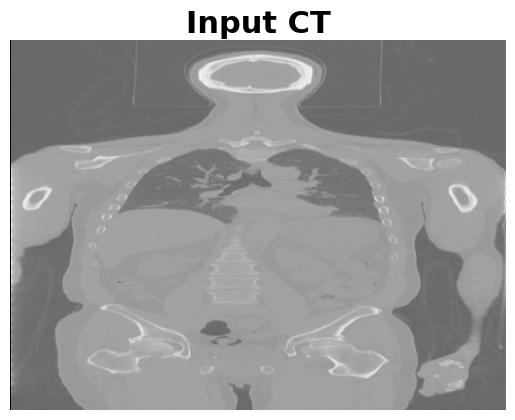

In [25]:
output_folder = output_folder_path
# find CT DICOM input in output folder
input_ct_path = None # path
output_subdir = config['subdir_names']
print(output_subdir)
for path in os.listdir(output_folder):
    if not path.endswith(".json") and not path.endswith(".log") and path not in output_subdir:
        input_ct_path = os.path.join(output_folder, path)
print("CT DICOM directory found at:", input_ct_path)
print(f"CT path exists: {os.path.exists(input_ct_path)}")

if os.path.isdir(input_ct_path):
    reader = sitk.ImageSeriesReader()
    series_id = reader.GetGDCMSeriesIDs(input_ct_path)[0]
    file_names = reader.GetGDCMSeriesFileNames(input_ct_path, series_id)
    reader.SetFileNames(file_names)
    img = reader.Execute()
    arr_zyx = sitk.GetArrayFromImage(img)          # (z, y, x)
    vol = arr_zyx       # -> (x, y, z)
    title = "Input CT"
    


else:
    # NIfTI file (nibabel)
    vol = nib.load(input_ct_path).get_fdata()
    if vol.ndim == 4:
        vol = vol[..., 0]
    title = "Input CT (NIfTI)"
    

# Plot slice
axis=1
cmap="gray"
slice_idx = vol.shape[axis] // 2
sl = np.take(vol, slice_idx, axis=axis)

plt.imshow(sl[::-1], cmap=cmap, aspect = 'auto')
plt.title(f"{title}")
plt.axis("off")
plt.show()

## SPECT PREPROCCESING OUTPUTS

### Setup 

In [26]:
# spect preprocessing outputs path
spect_preprocessing_dir_path = os.path.join(output_folder_path, config['subdir_names']['spect_preprocessing'])
print("Loading SPECT preprocessing outputs from:", spect_preprocessing_dir_path)
spect_preprocessing_prefix = config['spect_preprocessing']['name']



# Expected Outputs 
ct_nii_path = None

total_ml_path = None
body_ml_path = None
head_glands_cavities_ml_path = None

tdt_roi_seg_path = None

atn_bin_path = None
roi_seg_bin_path = None
body_seg_bin_path = None
roi_body_seg_bin_path = None



#files
plan = plan.copy()
# confirm run_totseg outputs (nii files)
ct_nii_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_ct.nii.gz')
ct_nii_exists = os.path.exists(ct_nii_path) if ct_nii_path else False

if plan['run_total']:
    total_ml_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_total_ml.nii.gz')
if plan['run_body']:
    body_ml_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_body_ml.nii.gz')
if plan['run_head_glands_cavities']:
    head_glands_cavities_ml_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_head_glands_cavities_ml.nii.gz')


total_ml_exists = os.path.exists(total_ml_path) if total_ml_path else False
body_ml_exists = os.path.exists(body_ml_path) if body_ml_path else False
head_glands_cavities_ml_exists = os.path.exists(head_glands_cavities_ml_path) if head_glands_cavities_ml_path else False


tdt_roi_seg_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_tdt_roi_seg.nii.gz')
tdt_roi_seg_exists = os.path.exists(tdt_roi_seg_path) if tdt_roi_seg_path else False

# check bin outputs
atn_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_atn_av.bin')
roi_seg_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_roi_seg.bin')
body_seg_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_body_seg.bin')
roi_body_seg_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_roi_body_seg.bin')

atn_bin_exists = os.path.exists(atn_bin_path) if atn_bin_path else False
roi_seg_bin_exists = os.path.exists(roi_seg_bin_path) if roi_seg_bin_path else False
body_seg_bin_exists = os.path.exists(body_seg_bin_path) if body_seg_bin_path else False
roi_body_seg_bin_exists = os.path.exists(roi_body_seg_bin_path) if roi_body_seg_bin_path else False

# Check Outputs
print("CT NIfTI path:", ct_nii_path)
print("CT NIfTI exists:", ct_nii_exists)

print("Total ML path:", total_ml_path)
print("Total ML exists:", total_ml_exists)
print("Body ML path:", body_ml_path)
print("Body ML exists:", body_ml_exists)
print("Head Glands and Cavities ML path:", head_glands_cavities_ml_path)
print("Head Glands and Cavities ML exists:", head_glands_cavities_ml_exists)

print("Total Segmentation ROI subset",tdt_roi_seg_path)
print("Total Segmentation ROI subset exists:", tdt_roi_seg_exists)

print("ATN binary path:", atn_bin_path)
print("ATN binary exists:", atn_bin_exists)
print("ROI Segmentation path:", roi_seg_bin_path)
print("ROI Segmentation exists:", roi_seg_bin_exists)
print("Body Segmentation path:", body_seg_bin_path)
print("Body Segmentation exists:", body_seg_bin_exists)
print("ROI and Body Segmentation path:", roi_body_seg_bin_path)
print("ROI and Body Segmentation exists:", roi_body_seg_bin_exists)

Loading SPECT preprocessing outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_preprocessing_outputs
CT NIfTI path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_preprocessing_outputs/spect_preprocessing_ct.nii.gz
CT NIfTI exists: True
Total ML path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_preprocessing_outputs/spect_preprocessing_total_ml.nii.gz
Total ML exists: True
Body ML path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_preprocessing_outputs/spect_preprocessing_body_ml.nii.gz
Body ML exists: True
Head Glands and Cavities ML path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_preprocessing_outputs/spect_preprocessing_head_glands_cavities_ml.nii.gz
Head Glands and Cavities ML exist

### Unify Total Seg Stage - NOTE skipped Seg Stage as gets unified to this stage!

#### load nii.gz files

In [27]:
def print_nii_info(name, img):
    """
    Print NIfTI image information."""
    hdr = img.header
    print(f"\n--- {name} ---")
    print(f"shape: {img.shape}, dtype: {hdr.get_data_dtype()}")
    print("voxel spacing mm (zooms):", hdr.get_zooms())
    print("affine:\n", img.affine)
    
#load nii files
ct_nii = nib.load(ct_nii_path)
roi_seg = nib.load(tdt_roi_seg_path)

# --- Print NIfTI info ---
print_nii_info("CT", ct_nii)
print_nii_info("ROI Seg", roi_seg)

# --- Arr spacing checks ---
ct_hdr = ct_nii.header
roi_hdr = roi_seg.header

ct_zooms = ct_hdr.get_zooms()
roi_zooms = roi_hdr.get_zooms()

print("\n--- Voxel Spacing Comparison (mm) ---")
print(f"CT voxel spacing (mm): {ct_zooms}")
print(f"ROI Seg voxel spacing (mm): {roi_zooms}")


--- CT ---
shape: (512, 512, 335), dtype: float64
voxel spacing mm (zooms): (np.float32(0.976562), np.float32(0.976562), np.float32(3.27))
affine:
 [[-9.76562023e-01  0.00000000e+00  0.00000000e+00  2.50000000e+02]
 [-0.00000000e+00  9.76562023e-01  0.00000000e+00 -2.49023178e+02]
 [ 0.00000000e+00 -0.00000000e+00  3.26999998e+00 -1.08168005e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

--- ROI Seg ---
shape: (512, 512, 335), dtype: uint8
voxel spacing mm (zooms): (np.float32(0.976562), np.float32(0.976562), np.float32(3.27))
affine:
 [[-9.76562023e-01  0.00000000e+00  0.00000000e+00  2.50000000e+02]
 [-0.00000000e+00  9.76562023e-01  0.00000000e+00 -2.49023178e+02]
 [ 0.00000000e+00 -0.00000000e+00  3.26999998e+00 -1.08168005e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

--- Voxel Spacing Comparison (mm) ---
CT voxel spacing (mm): (np.float32(0.976562), np.float32(0.976562), np.float32(3.27))
ROI Seg voxel spacing (mm): (np.floa

#### Plot Nii.gz files

(335, 512, 512)


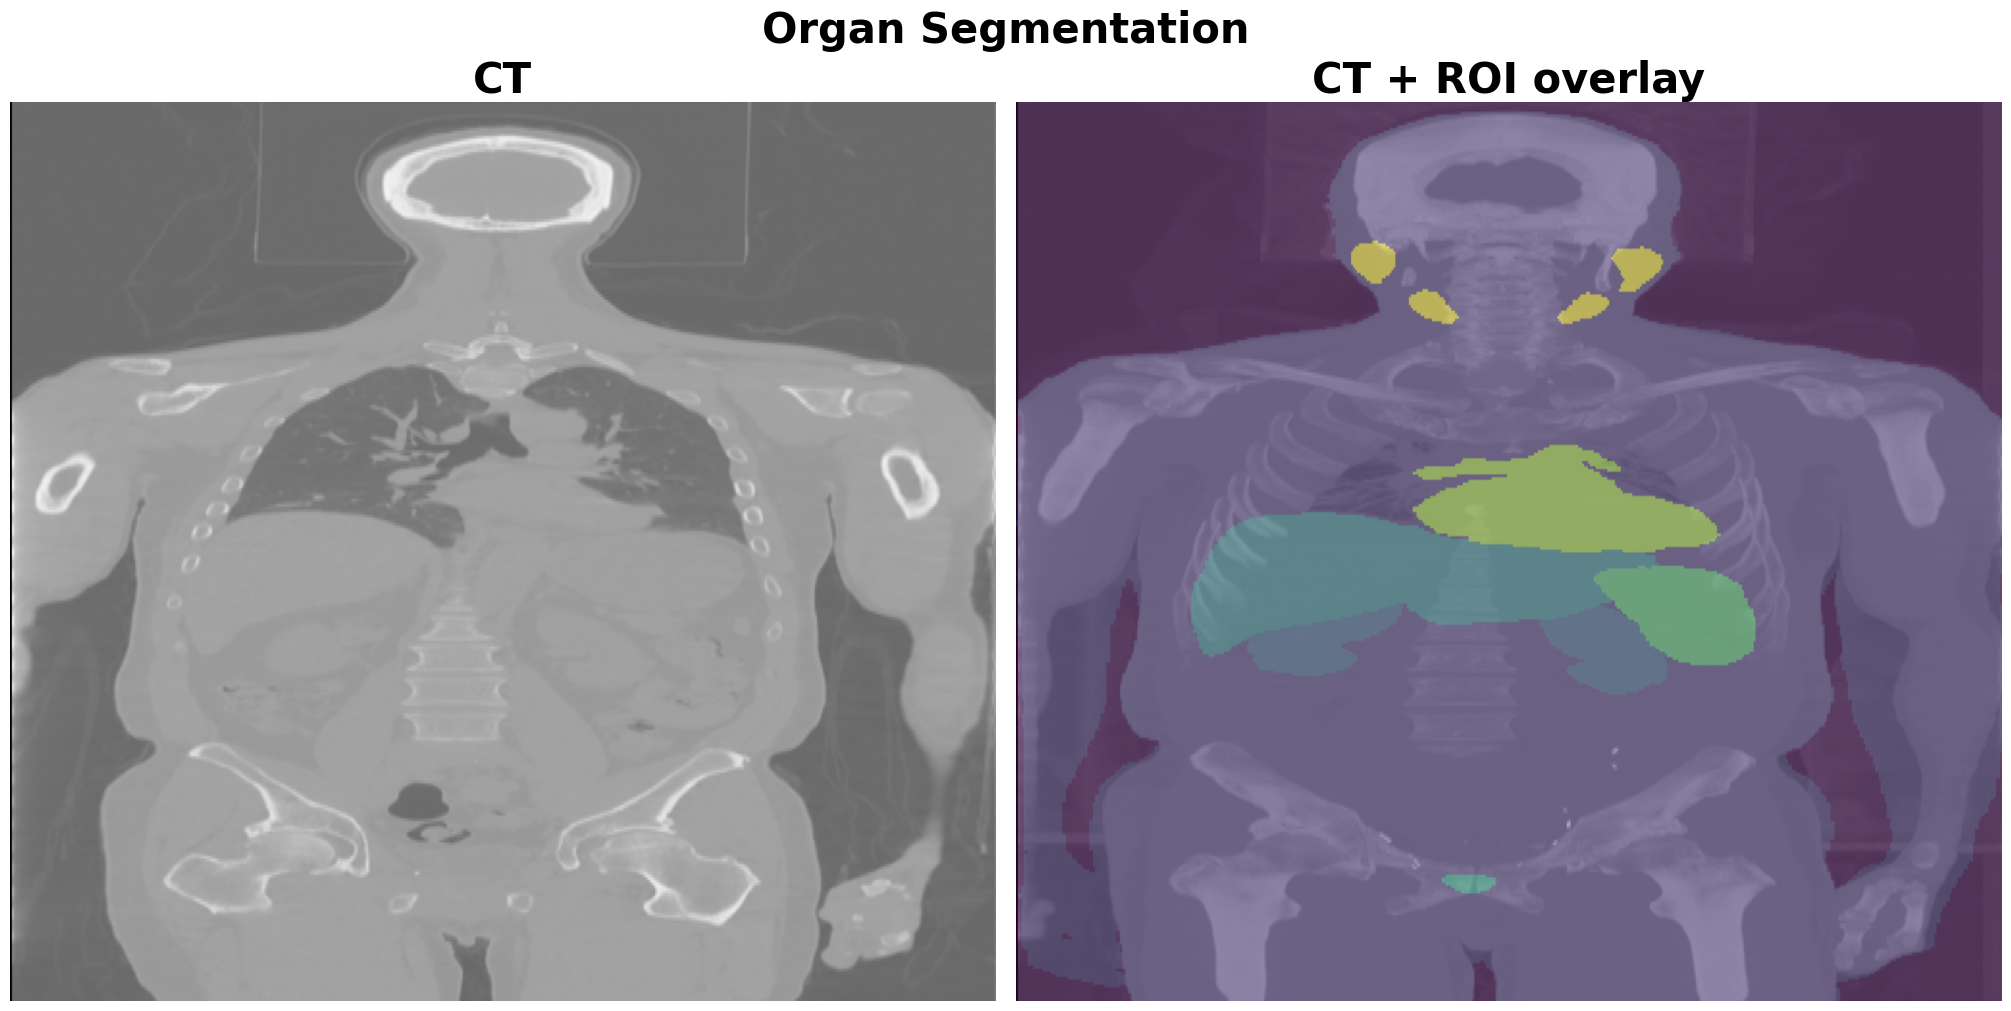

In [28]:
# ------- PLOT SLICES WITH OVERLAYS -------
# data arrays
ct_data   = np.array(ct_nii.get_fdata().transpose((2, 1, 0)), dtype=np.float32)
roi_data  = np.array(roi_seg.get_fdata().transpose((2, 1, 0)), dtype=np.float32)

# select middle slice index in y-direction
slice_index = ct_data.shape[1] // 2

ct_sl   = ct_data[:, slice_index, :]
roi_sl  = roi_data[:, slice_index, :]

ncols = 2
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(10*ncols, 10*nrows), constrained_layout=True)

# 1) CT only
ax[0].imshow(ct_sl[::-1], cmap="gray",aspect='auto')
ax[0].set_title("CT",fontsize=30)
ax[0].axis("off")
print(ct_data.shape)
# 2) CT + ROI overlay (mask zeros so background is transparent)
ax[1].imshow(np.max(ct_data[:,250:325,:],axis = 1)[::-1], cmap="gray",aspect='auto')
im1 = ax[1].imshow(np.max(roi_data,axis = 1)[::-1], alpha=0.45,aspect='auto')  
ax[1].set_title("CT + ROI overlay",fontsize=30)
ax[1].axis("off")

fig.suptitle(f"Organ Segmentation", fontsize=30)
plt.show()

### Preprocess Stage

#### Resize to User Specfied scale factor from config

In [29]:
# --- Resize ROI array and compute new pixel spacing ---
# should be same for all
shape = roi_data.shape
print("Original ROI shape:", roi_data.shape)
print("Array Type:", roi_data.dtype) 

resize = config['spect_preprocessing']['xy_dim']
scale = resize / roi_data.shape[1]
print ("Resizing factor:", scale)
print("NOTE: Z dimension is also resized equally to maintain isotropic voxels.")
roi_data_new = zoom(roi_data, (scale, scale, scale), order=0)
shape_new = roi_data_new.shape
print("Resized ROI shape:", shape_new)

zooms_mm = np.array(ct_nii.header.get_zooms()[:3], dtype=float) / scale
zooms_mm = zooms_mm[[2, 1, 0]]
arr_px_spacing_cm = tuple(float(x) * 0.1 for x in zooms_mm)
print(f"Array pixel spacing resized (cm): {arr_px_spacing_cm}")

Original ROI shape: (335, 512, 512)
Array Type: float32
Resizing factor: 0.5
NOTE: Z dimension is also resized equally to maintain isotropic voxels.
Resized ROI shape: (168, 256, 256)
Array pixel spacing resized (cm): (0.6539999961853028, 0.19531240463256838, 0.19531240463256838)


#### Load and plot .bin files

ROI unique values: [0. 1. 2. 3. 4. 5. 6. 7.]
Body unique values: [0. 1.]
ROI+Body unique values: [0. 1. 2. 3. 4. 5. 6. 7.]


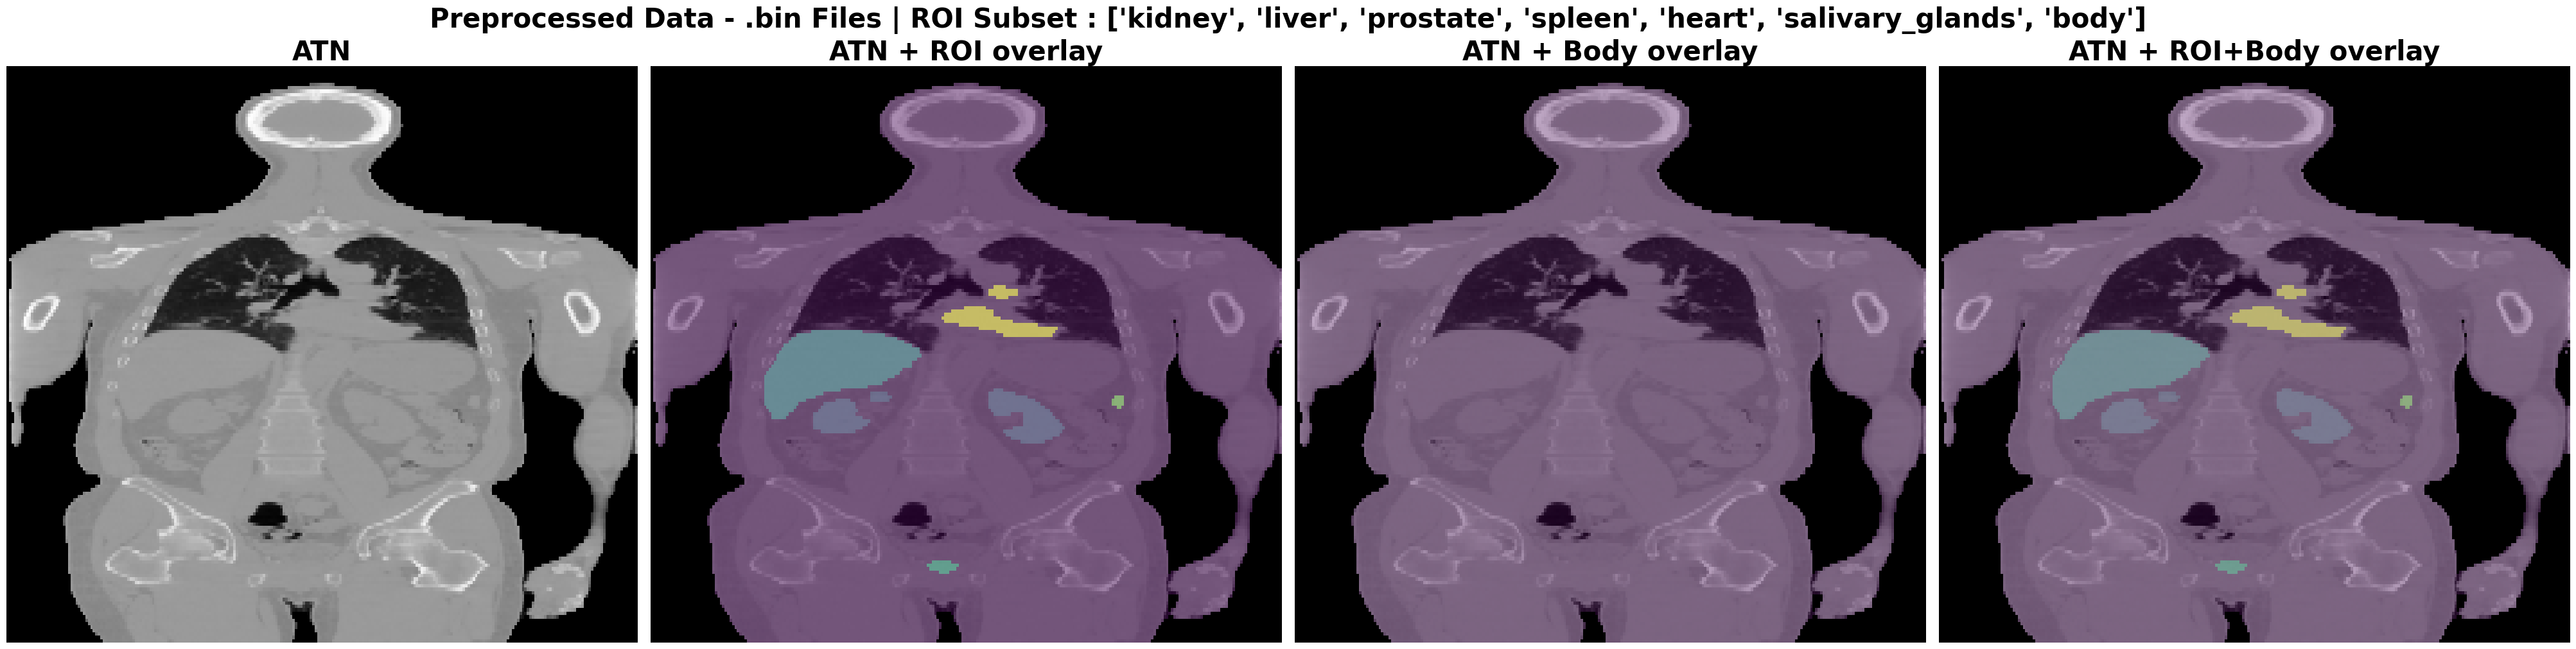

In [30]:
# ------- BIN FILES PLOTS -------
# data arrays

shape_new = roi_data_new.shape
atn_data = np.fromfile(atn_bin_path, dtype=np.float32).reshape(shape_new)
roi_data = np.fromfile(roi_seg_bin_path, dtype=np.float32).reshape(shape_new)
body_data = np.fromfile(body_seg_bin_path, dtype=np.float32).reshape(shape_new)
roi_body_data = np.fromfile(roi_body_seg_bin_path, dtype=np.float32).reshape(shape_new)

print(f"ROI unique values: {np.unique(roi_data)}")
print(f"Body unique values: {np.unique(body_data)}")
print(f"ROI+Body unique values: {np.unique(roi_body_data)}")

slice_index = atn_data.shape[1] // 2

atn_sl   = atn_data[:, slice_index, :]
roi_sl  = roi_data[:, slice_index, :]
body_sl = body_data[:, slice_index, :]
roi_body_sl = roi_body_data[:, slice_index, :]

ncols = 4
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(10*ncols, 10*nrows), constrained_layout=True)


# 1) ATN only
ax[0].imshow(atn_sl[::-1], cmap="gray", aspect='auto')
ax[0].set_title("ATN",fontsize=30)
ax[0].axis("off")

# 2) ATN + ROI overlay (mask zeros so background is transparent)
ax[1].imshow(atn_sl[::-1], cmap="gray", aspect='auto')
roi_masked = np.ma.masked_where(roi_sl == 0, roi_sl)
im1 = ax[1].imshow(roi_masked[::-1], alpha=0.45, aspect='auto')
ax[1].set_title("ATN + ROI overlay",fontsize=30)
ax[1].axis("off")

# 3) ATN + Body overlay
ax[2].imshow(atn_sl[::-1], cmap="gray", aspect='auto')
body_masked = np.ma.masked_where(body_sl == 0, body_sl)
im2 = ax[2].imshow(body_masked[::-1], alpha=0.35, aspect='auto')
ax[2].set_title("ATN + Body overlay",fontsize=30)
ax[2].axis("off")

# 4) ATN + ROI+Body overlay
ax[3].imshow(atn_sl[::-1], cmap="gray", aspect='auto')
roi_body_masked = np.ma.masked_where(roi_body_sl == 0, roi_body_sl)
im3 = ax[3].imshow(roi_body_masked[::-1], alpha=0.35, aspect='auto')
ax[3].set_title("ATN + ROI+Body overlay",fontsize=30)
ax[3].axis("off")   


fig.suptitle(f"Preprocessed Data - .bin Files | ROI Subset : {roi_list}", fontsize=30)
plt.show()


## SPECT PBPK OUTPUTS

### Setup

In [31]:
pbpk_dir_path = os.path.join(output_folder_path, config['subdir_names']['pbpk'])
print("Loading PBPK outputs from:", pbpk_dir_path)
pbpk_prefix = config['pbpk']['name']

# check PBPK outputs TAC from PyCNO
frames_start_times = config['pbpk']['FrameStartTimes'] # all frames start times [min]

# grab shape details: 
shape  = shape_new
print("Shape of arrays:", shape) # all should be the same shape

# grab vois for PyCNO
vois = [v.lower() for v in config["pbpk"]["VOIs"]]
print("PBPK VOIs:", vois)

# grab rois from totalseg
rois = roi_list.copy()
print("Totalseg ROIs:", rois)

Loading PBPK outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/pbpk_outputs
Shape of arrays: (168, 256, 256)
PBPK VOIs: ['tumor1', 'tumor2', 'kidney', 'heart', 'sg', 'bone', 'tumorrest', 'spleen', 'liver', 'prostate', 'gi', 'rest', 'skin', 'muscle', 'brain', 'redmarrow', 'lungs', 'adipose']
Totalseg ROIs: ['kidney', 'liver', 'prostate', 'spleen', 'heart', 'salivary_glands', 'body']


### PBPK STAGE

#### TAC Produced Via PyCNO (Activty per ROI per Frame)

ROI: kidney
Frame Time : 2 hrs | Activity: 336.4990234375 MBq
Frame Time : 24 hrs | Activity: 150.82276916503906 MBq
Frame Time : 48 hrs | Activity: 64.46153259277344 MBq
Frame Time : 77 hrs | Activity: 29.4718017578125 MBq
Frame Time : 156 hrs | Activity: 3.998861074447632 MBq
ROI: liver
Frame Time : 2 hrs | Activity: 530.9000244140625 MBq
Frame Time : 24 hrs | Activity: 93.45641326904297 MBq
Frame Time : 48 hrs | Activity: 36.079708099365234 MBq
Frame Time : 77 hrs | Activity: 16.410537719726562 MBq
Frame Time : 156 hrs | Activity: 2.226633071899414 MBq
ROI: prostate
Frame Time : 2 hrs | Activity: 11.51555061340332 MBq
Frame Time : 24 hrs | Activity: 4.7465410232543945 MBq
Frame Time : 48 hrs | Activity: 2.440030336380005 MBq
Frame Time : 77 hrs | Activity: 1.1652425527572632 MBq
Frame Time : 156 hrs | Activity: 0.1588822603225708 MBq
ROI: spleen
Frame Time : 2 hrs | Activity: 13.40817928314209 MBq
Frame Time : 24 hrs | Activity: 1.6391205787658691 MBq
Frame Time : 48 hrs | Activity:

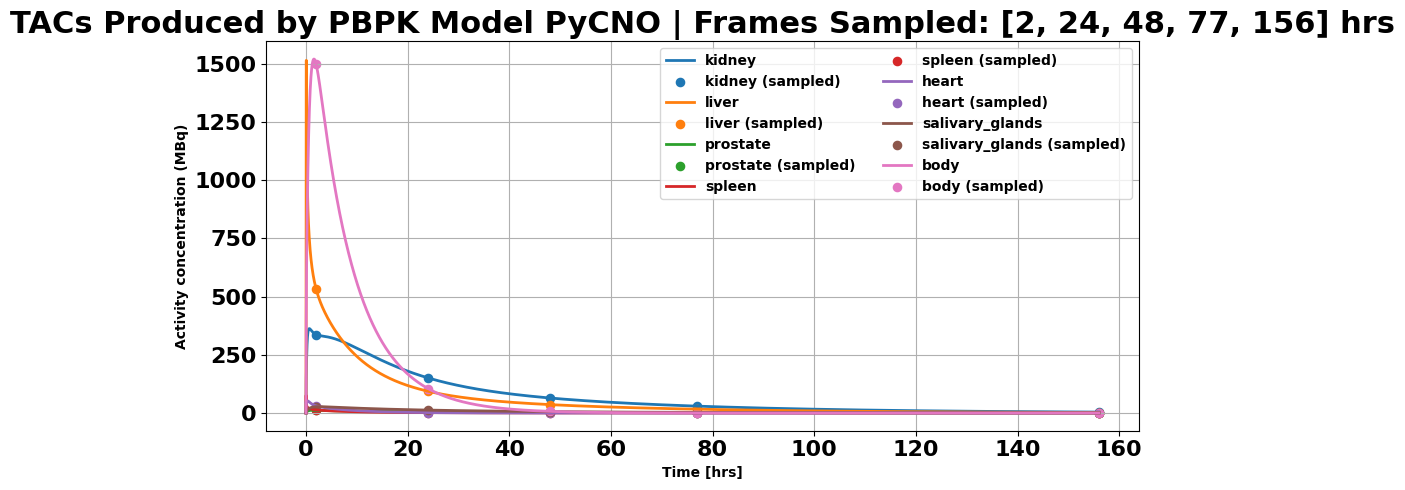

In [32]:
mpl.rcParams.update({
    "font.size": 10,              # base size
    "font.weight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 22,
    "figure.titlesize": 26,
    "figure.titleweight": "bold",
    "axes.labelweight": "bold",
    "axes.labelsize": 10,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

# ------- LOAD TAC BIN FILES-------
def load_tac_bins(roi, base_path=pbpk_dir_path, pbpk_prefix=pbpk_prefix):
    roi = roi.lower()
    t  = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_TAC_time.bin"), dtype=np.float32)
    act  = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_TAC_values.bin"), dtype=np.float32)
    t_s = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_sample_times.bin"), dtype=np.float32)
    act_s = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_sample_values.bin"), dtype=np.float32)
    return t, act, t_s, act_s

# --- One plot for all ROIs ---
plt.figure(figsize=(10, 5))

sampled_activity = {}

for roi in rois:
    roi = roi.lower()
    t_file = os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{roi}_TAC_time.bin")
    if not os.path.exists(t_file):
        print(f"Skipping '{roi}' (missing files).")
        continue

    t, act, t_s, act_s = load_tac_bins(roi)

    plt.plot(t/60, act, linewidth=2, label=f"{roi}")
    plt.scatter(t_s/60, act_s, s=35, label=f"{roi} (sampled)")
    sampled_activity[roi] = act_s.astype(float).tolist()
for roi in sampled_activity:
    print(f"ROI: {roi}")
    for indx, fr in enumerate(frames_start_times):
        print(f"Frame Time : {int(fr/60)} hrs | Activity: {sampled_activity[roi][indx]} MBq")

plt.title(f"TACs Produced by PBPK Model PyCNO | Frames Sampled: {[int(f/60) for f in frames_start_times]} hrs")
plt.xlabel("Time [hrs]")
plt.ylabel("Activity concentration (MBq)")
plt.grid()
plt.legend(ncol=2)  # makes legend less tall if many ROIs
plt.tight_layout()
plt.show()

#### Volumes of each ROI - Assume Activity Map uniform activty across organ

ROI List: ['kidney', 'liver', 'prostate', 'spleen', 'heart', 'salivary_glands', 'body']
Unique values in ROI+Body data: [0 1 2 3 4 5 6 7]
Class map: {'body': 1, 'kidney': 2, 'liver': 3, 'prostate': 4, 'spleen': 5, 'heart': 6, 'salivary_glands': 7}


Calculating volumes for each ROI:
-----


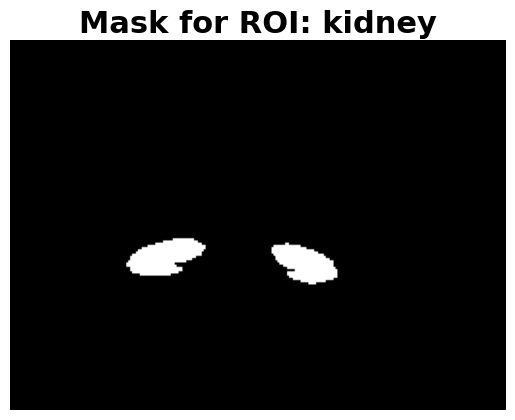

Number of voxels in kidney: 15437
Voxel volume (cm^3): 0.024948095608275895
Volume of kidney: 385.12 cm^3
-----
-----


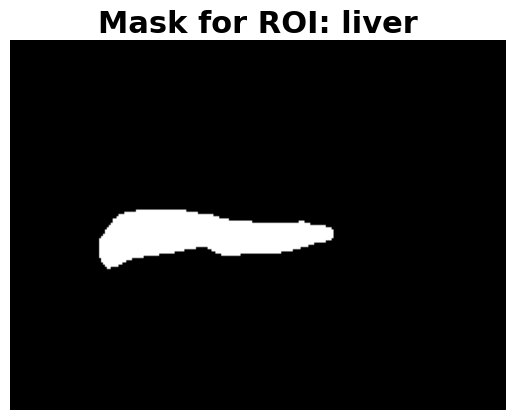

Number of voxels in liver: 68800
Voxel volume (cm^3): 0.024948095608275895
Volume of liver: 1716.43 cm^3
-----
-----


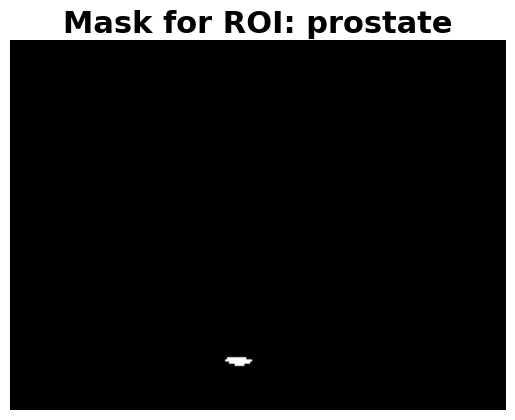

Number of voxels in prostate: 162
Voxel volume (cm^3): 0.024948095608275895
Volume of prostate: 4.04 cm^3
-----
-----


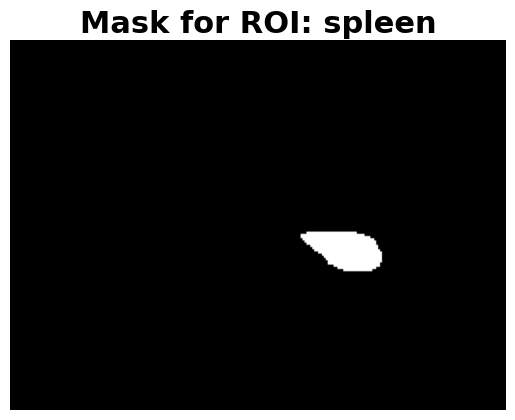

Number of voxels in spleen: 6923
Voxel volume (cm^3): 0.024948095608275895
Volume of spleen: 172.72 cm^3
-----
-----


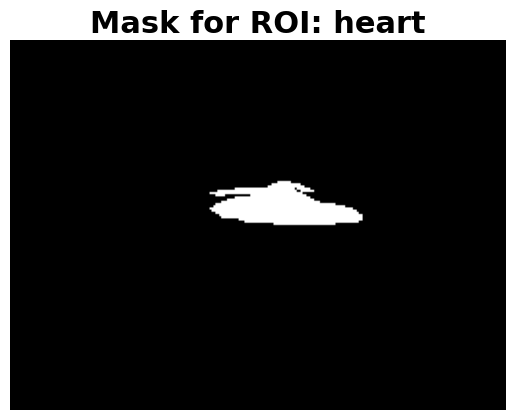

Number of voxels in heart: 22824
Voxel volume (cm^3): 0.024948095608275895
Volume of heart: 569.42 cm^3
-----
-----


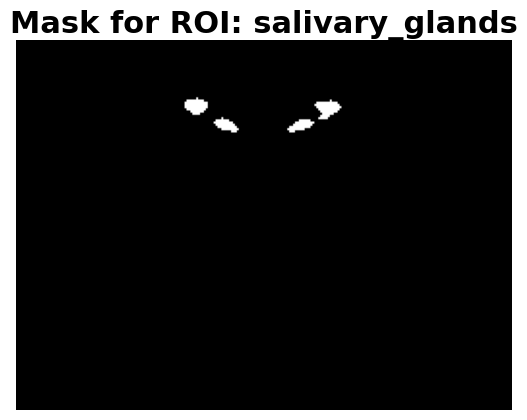

Number of voxels in salivary_glands: 2220
Voxel volume (cm^3): 0.024948095608275895
Volume of salivary_glands: 55.38 cm^3
-----
-----


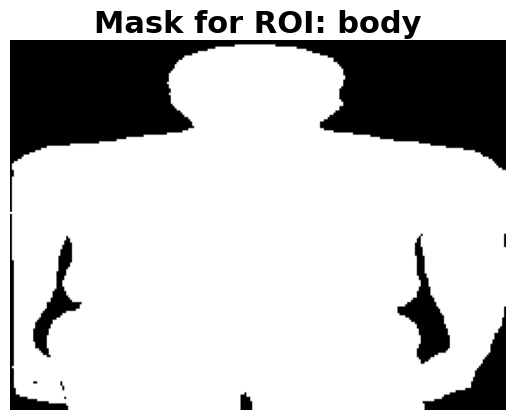

Number of voxels in body: 2326569
Voxel volume (cm^3): 0.024948095608275895
Volume of body: 58043.47 cm^3
-----
Calculated Volumes (cm^3): {'kidney': 385.123751904955, 'liver': 1716.4289778493817, 'prostate': 4.041591488540695, 'spleen': 172.715665896094, 'heart': 569.415334163289, 'salivary_glands': 55.384772250372485, 'body': 58043.46585125084}


In [33]:
# find volumes of each ROI region :
roi_list = roi_list.copy() 
print(f"ROI List: {roi_list}")
# to avoid modifying original data
roi_body_data = np.fromfile(os.path.join(spect_preprocessing_dir_path, 
                                        f"{spect_preprocessing_prefix}_roi_body_seg.bin"),
                                        np.float32).reshape(shape).astype(int) 
unique_values = np.unique(roi_body_data.astype(int))
print("Unique values in ROI+Body data:", unique_values)

def _build_class_map(arr, unique_values, classes):
        class_map = {}
        for value in unique_values:
            if value == 0:
                continue
            name = classes.get(str(value))
            if name is not None:
                class_map[name] = int(value)
        return class_map
    
# classes
TDT_Pipeline:{ 
    "0": "background",
    "1": "body",
    "2": "kidney",
    "3": "liver",
    "4": "prostate",
    "5": "spleen",
    "6": "heart",
    "7": "salivary_glands"
}

classes = {
    "0": "background",
    "1": "body",
    "2": "kidney",
    "3": "liver",
    "4": "prostate",
    "5": "spleen",
    "6": "heart",
    "7": "salivary_glands"
}
class_map = _build_class_map(roi_body_data, unique_values, classes)
print("Class map:", class_map)
print("\n")

volume_roi = {}
mask_roi = {}
print("Calculating volumes for each ROI:")
for roi in roi_list:
    print("-----")
    mask = (roi_body_data == class_map.get(roi))
    plt.imshow(np.max(mask[::-1], axis=1), cmap="gray", aspect='auto')
    plt.title(f"Mask for ROI: {roi}")
    plt.axis("off")
    plt.show()
    
    volume_voxels = np.sum(mask) # count voxels in mask
    print(f"Number of voxels in {roi}: {volume_voxels}")
    voxel_volume_cm3 = arr_px_spacing_cm[0] * arr_px_spacing_cm[1] * arr_px_spacing_cm[2]  # assuming same spacing for all roi
    print(f"Voxel volume (cm^3): {voxel_volume_cm3}")
    volume_cm3 = volume_voxels * voxel_volume_cm3
    print(f"Volume of {roi}: {volume_cm3:.2f} cm^3")
    print("-----")
    volume_roi[str(roi)] = float(volume_cm3)
    mask_roi[str(roi)] = mask.astype(np.uint8)
    

print("Calculated Volumes (cm^3):", volume_roi)


#### Check outputs for PBPK Activty Maps (.bin files)

Using shape for PBPK frames: (168, 256, 256)


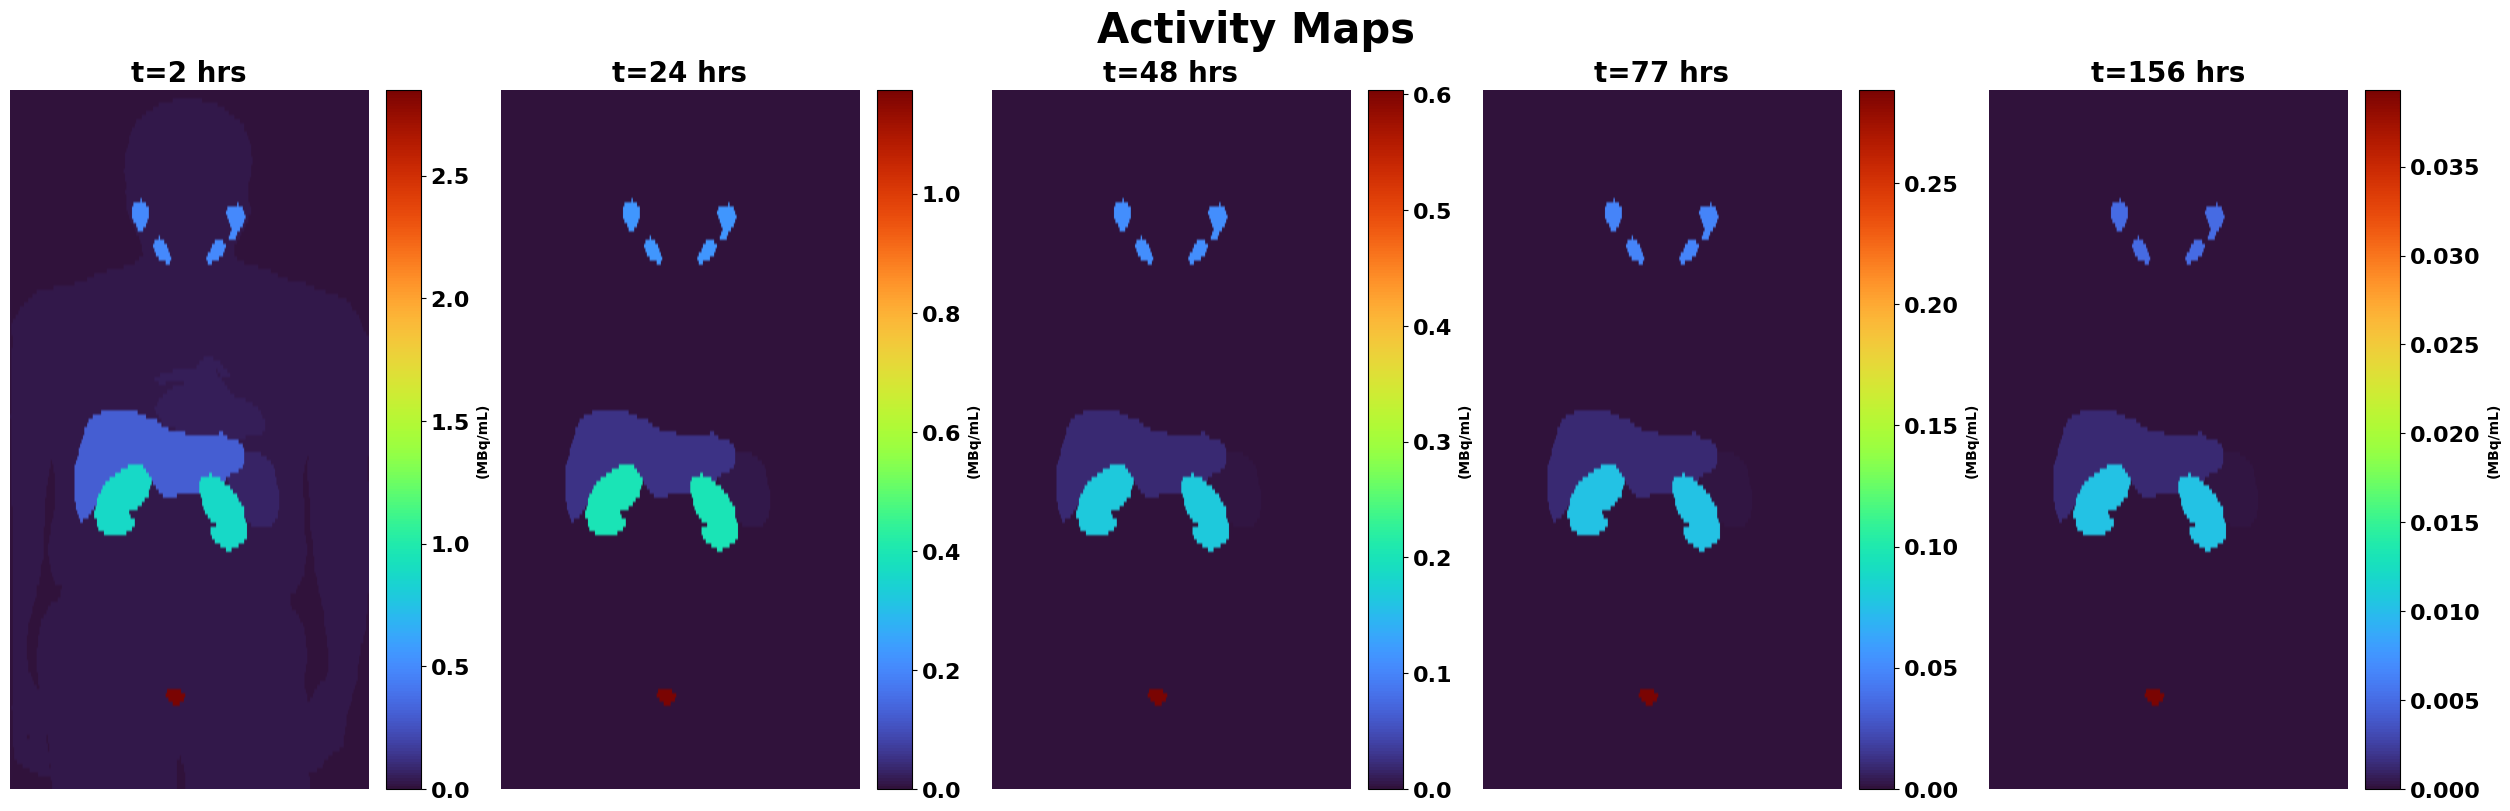

In [34]:
titles = []
arr = []
shape = shape_new
print("Using shape for PBPK frames:", shape)

for frame in frames_start_times:
    pbpk_frame_arr = np.fromfile(
        os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{int(frame)}_act_av.bin"),
        dtype=np.float32
    ).reshape(shape)
    arr.append(pbpk_frame_arr)
    titles.append(f"t={int(frame/60)} hrs")

ncols = len(arr)
fig, axes = plt.subplots(1, ncols, figsize=(5*ncols, 8), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

for i, ax in enumerate(axes):
    img = np.max(arr[i], axis=1)[::-1]
    im = ax.imshow(img, cmap="turbo", aspect="auto")
    ax.set_title(titles[i], fontsize=20)
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="(MBq/mL)")

fig.suptitle("Activity Maps", fontsize=30)
plt.show()


#### Ogran-based PBPK Actitvty Map (.bin) - Check bin made correctly -> fed into simind

Using shape for PBPK frames: (168, 256, 256)


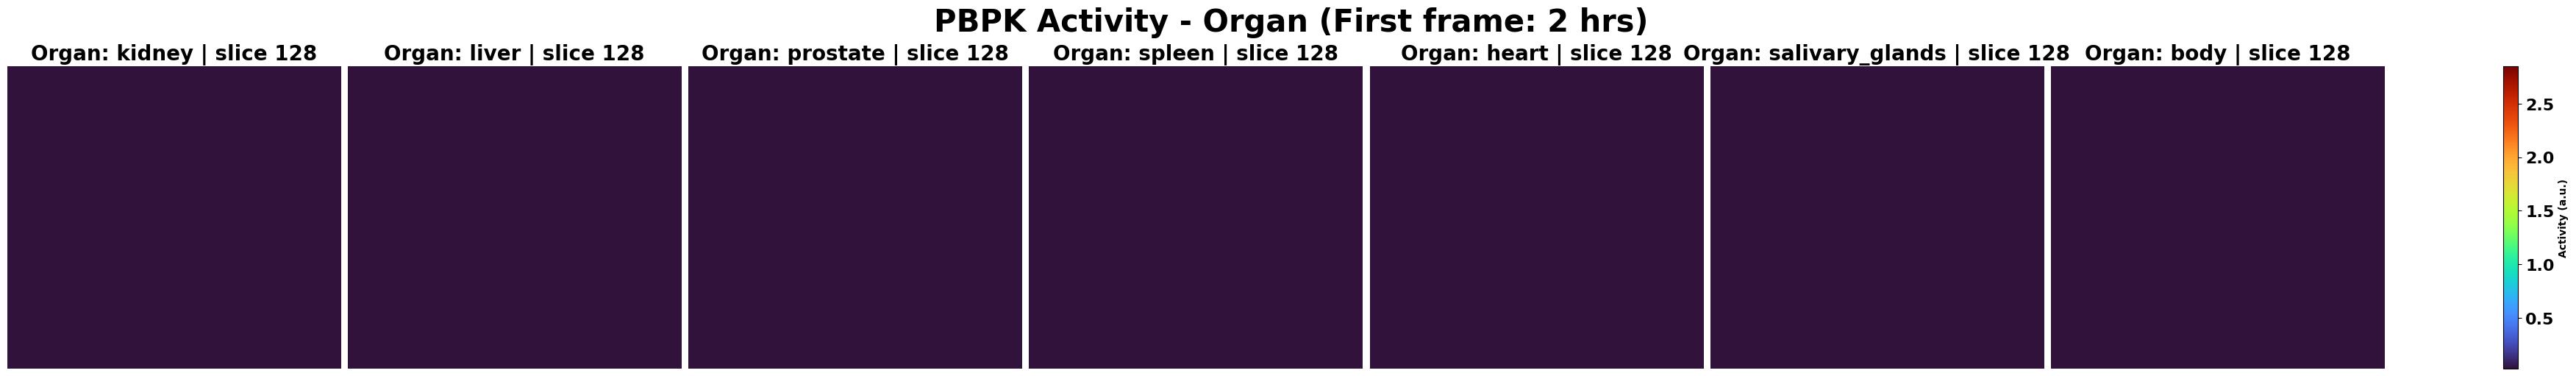

In [35]:
slices = []
titles = []
global_min = np.inf
global_max = -np.inf
shape = shape_new
print("Using shape for PBPK frames:", shape)
for organ in roi_list:
    pbpk_frame_arr = np.fromfile(os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{organ}_act_av.bin"), dtype=np.float32).reshape(shape)
    
    slice_index = pbpk_frame_arr.shape[1] // 2  # same slice for all frames
    sl = pbpk_frame_arr[:, slice_index, :]
    
    # update global min/max (nan-safe)
    sl_min = np.nanmin(sl)
    sl_max = np.nanmax(sl)
    if sl_min < global_min: global_min = sl_min
    if sl_max > global_max: global_max = sl_max

    slices.append(sl)
    titles.append(f"Organ: {organ} | slice {slice_index}")
    
# Common choice for activity maps:
vmax = float(global_max) if np.isfinite(global_max) else 1.0

ncols = len(slices)
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

im = None
for i, ax in enumerate(axes):
    if i < len(slices):
        vmin = slices[i].max()
        im = ax.imshow(slices[i][::-1], cmap="turbo", vmin = vmin, vmax=vmax, aspect='auto')
        ax.set_title(titles[i], fontsize=20)
        ax.axis("off")
    else:
        ax.axis("off")

# one shared colorbar for the whole figure
fig.colorbar(im, ax=axes.tolist(), label="Activity (a.u.)")
fig.suptitle(f"PBPK Activity - Organ (First frame: {int(frames_start_times[0]/60)} hrs)", fontsize=30)
plt.show()

### Confirming Correct Activity values in Activity Map (.bin)

#### Exepcted Activity via TAC + Volumes

In [36]:
frames_start_times = config['pbpk']['FrameStartTimes'] # all frames start times [min]
TAC_sampled_values = sampled_activity # units of MBq, correpond to each frame
print("TAC Sampled Values:", TAC_sampled_values)
print("TAC Frame Start Times (hrs):", [int(f/60) for f in frames_start_times])

# map roi activity to aquire roi : Mbq/ml value
# assuming each roi has same activity uniformaly distributed
# assuming 1 ml = 1 cm^3
masks = mask_roi
volumes = volume_roi
roi_activity_Mbq_ml_expected = {}
for roi in roi_list:
    roi = roi.lower()
    print(f"--- ROI: {roi} ---")
    volume_cm3 = volumes.get(str(roi))  # in cm^3
    activity_values = TAC_sampled_values.get(roi)  # in MBq
    activity_Mbq_per_ml = []
    for activity in activity_values:
        activity_conc = activity / volume_cm3  # MBq/ml
        activity_Mbq_per_ml.append(activity_conc)
        print(f"Activity: {activity} MBq | Volume: {volume_cm3:.2f} cm^3 | Activity Concentration: {activity_conc:.2f} MBq/ml")
    roi_activity_Mbq_ml_expected[str(roi)] = activity_Mbq_per_ml
print("\n")
print(f"Expected ROI Activty [Mbq/ml]:\n{roi_activity_Mbq_ml_expected}")

TAC Sampled Values: {'kidney': [336.4990234375, 150.82276916503906, 64.46153259277344, 29.4718017578125, 3.998861074447632], 'liver': [530.9000244140625, 93.45641326904297, 36.079708099365234, 16.410537719726562, 2.226633071899414], 'prostate': [11.51555061340332, 4.7465410232543945, 2.440030336380005, 1.1652425527572632, 0.1588822603225708], 'spleen': [13.40817928314209, 1.6391205787658691, 0.5164782404899597, 0.22493158280849457, 0.030379557982087135], 'heart': [30.563703536987305, 1.955636978149414, 0.13334235548973083, 0.0056873951107263565, 1.1411974583097617e-06], 'salivary_glands': [27.218236923217773, 12.553680419921875, 6.028256416320801, 2.6274445056915283, 0.2788906991481781], 'body': [1496.189208984375, 105.03407287597656, 7.118063449859619, 0.30304014682769775, 6.077211583033204e-05]}
TAC Frame Start Times (hrs): [2, 24, 48, 77, 156]
--- ROI: kidney ---
Activity: 336.4990234375 MBq | Volume: 385.12 cm^3 | Activity Concentration: 0.87 MBq/ml
Activity: 150.82276916503906 MBq

#### Calcualted Activity via .bin files

In [37]:
# map roi activity to aquire roi : Mbq/ml value
# assuming each roi has same activity uniformaly distributed
# assuming 1 ml = 1 cm^3
masks = mask_roi
shape  = shape_new
print("Using shape for PBPK frames:", shape)
roi_activity_Mbq_ml_calculated = {}

for roi in roi_list:
    # create activity map based on roi masks and activity concentrations
    roi_activites = []
    roi = roi.lower()
    mask = masks.get(str(roi))
    for frame in frames_start_times:
        pbpk_frame_arr = np.fromfile(os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{frame}_act_av.bin"), dtype=np.float32).reshape(shape)
        vals = pbpk_frame_arr[mask.astype(bool)]
        roi_mean = float(vals.mean())
        roi_activites.append(roi_mean)
    roi_activity_Mbq_ml_calculated[str(roi)] = roi_activites

print("\n")
print("Calculated ROI Activty [Mbq/ml]:\n")
for roi in roi_activity_Mbq_ml_calculated:
    print(f"ROI: {roi} | Activities: {[round(act, 4) for act in roi_activity_Mbq_ml_calculated[roi]]} Mbq/ml")


Using shape for PBPK frames: (168, 256, 256)


Calculated ROI Activty [Mbq/ml]:

ROI: kidney | Activities: [0.8737, 0.3916, 0.1674, 0.0765, 0.0104] Mbq/ml
ROI: liver | Activities: [0.3093, 0.0544, 0.021, 0.0096, 0.0013] Mbq/ml
ROI: prostate | Activities: [2.8493, 1.1744, 0.6037, 0.2883, 0.0393] Mbq/ml
ROI: spleen | Activities: [0.0776, 0.0095, 0.003, 0.0013, 0.0002] Mbq/ml
ROI: heart | Activities: [0.0537, 0.0034, 0.0002, 0.0, 0.0] Mbq/ml
ROI: salivary_glands | Activities: [0.4914, 0.2267, 0.1088, 0.0474, 0.005] Mbq/ml
ROI: body | Activities: [0.0258, 0.0018, 0.0001, 0.0, 0.0] Mbq/ml


#### Calculated Activity vs Exepcted Activity

In [38]:
calculated_activty = roi_activity_Mbq_ml_calculated
expected_activty = roi_activity_Mbq_ml_expected
print("Exepcting all difference be = 0")
for roi in roi_list:
    print(f"--- ROI: {roi} ---")
    calc_values = calculated_activty.get(str(roi))
    exp_values = expected_activty.get(str(roi))
    for indx, fr in enumerate(frames_start_times):
        calc_val = calc_values[indx]
        exp_val = exp_values[indx]
        some_val = calc_val/exp_val
        diff = abs(calc_val - exp_val) 
        print(f"Frame Time : {int(fr/60)} hrs | Calculated Activity: {calc_val:.4f} MBq/ml | Expected Activity: {exp_val:.4f} MBq/ml")
        print(f"Difference: {diff:.4f} MBq/ml")
    print("\n")
        


Exepcting all difference be = 0
--- ROI: kidney ---
Frame Time : 2 hrs | Calculated Activity: 0.8737 MBq/ml | Expected Activity: 0.8737 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 24 hrs | Calculated Activity: 0.3916 MBq/ml | Expected Activity: 0.3916 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 48 hrs | Calculated Activity: 0.1674 MBq/ml | Expected Activity: 0.1674 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 77 hrs | Calculated Activity: 0.0765 MBq/ml | Expected Activity: 0.0765 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 156 hrs | Calculated Activity: 0.0104 MBq/ml | Expected Activity: 0.0104 MBq/ml
Difference: 0.0000 MBq/ml


--- ROI: liver ---
Frame Time : 2 hrs | Calculated Activity: 0.3093 MBq/ml | Expected Activity: 0.3093 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 24 hrs | Calculated Activity: 0.0544 MBq/ml | Expected Activity: 0.0544 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 48 hrs | Calculated Activity: 0.0210 MBq/ml | Expected Activity: 0.0210 MBq/ml
Difference

## SPECT Simulation

### Setup

In [39]:
spect_sim_dir_path = os.path.join(output_folder_path, config['subdir_names']['spect_simulation'])
print("Loading SPECT simulation outputs from:", spect_sim_dir_path)
spect_sim_prefix = config['spect_simulation']['name']

simind_workdir_path = os.path.join(spect_sim_dir_path, f"simind_work")
print("Loading SIMIND workdir from:", simind_workdir_path)

Loading SPECT simulation outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs
Loading SIMIND workdir from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/simind_work


### SIMIND Stage

#### SIMIND needed parameters

In [40]:
num_projections = config['spect_simulation']['NumProjections']
num_photons = config['spect_simulation']['NumPhotons']
OutputImgSize = config['spect_simulation']['OutputImgSize']
OutputPixelWidth = config['spect_simulation']['OutputPixelWidth']
OutputSliceWidth = config['spect_simulation']['OutputSliceWidth']


print(f"Number of photons: {num_photons:g}")
input_slice_width = arr_px_spacing_cm[0]
output_img_length = int(input_slice_width * shape[0] / OutputSliceWidth)
print(f"Output image length (cm): {output_img_length}")

simind_shape = (num_projections, output_img_length, OutputImgSize)
print(f"SIMIND output shape: {simind_shape}")

Number of photons: 5e+08
Output image length (cm): 439
SIMIND output shape: (64, 439, 256)


#### SIMIND: Frame-Based Projection Plots  (without Possion Noise)

Plotting SIMIND projections for windows: ['w1', 'w2', 'w3']
NOTE: This is prior to any reconstruction step or poisson noise addition.
--- Frame: 2 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min_tot_w3.a00


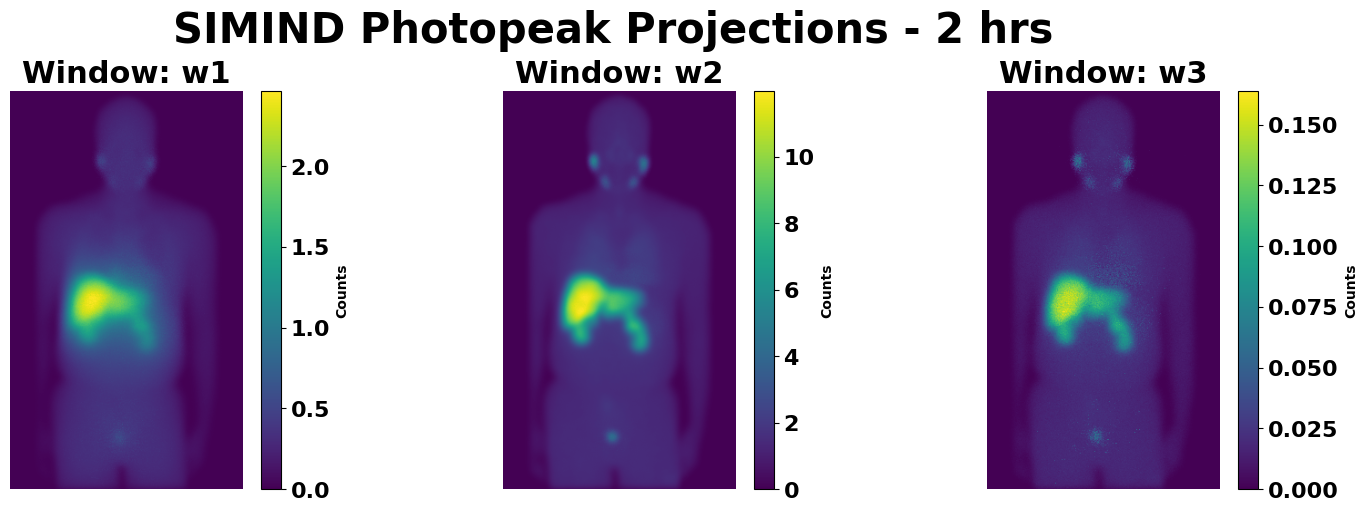

--- Frame: 24 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min_tot_w3.a00


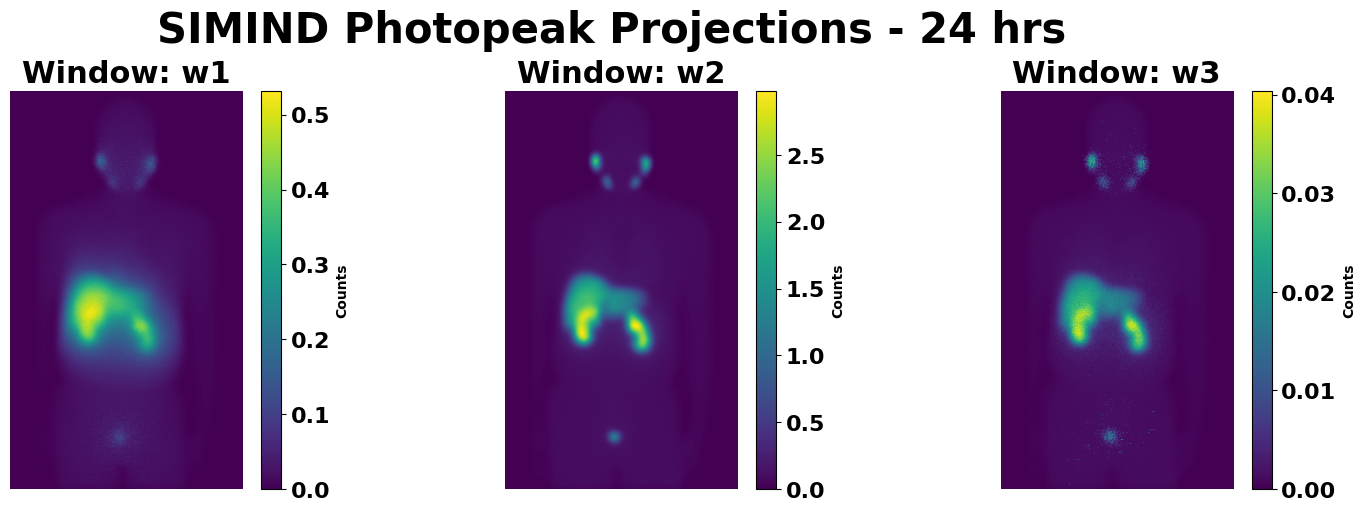

--- Frame: 48 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min_tot_w3.a00


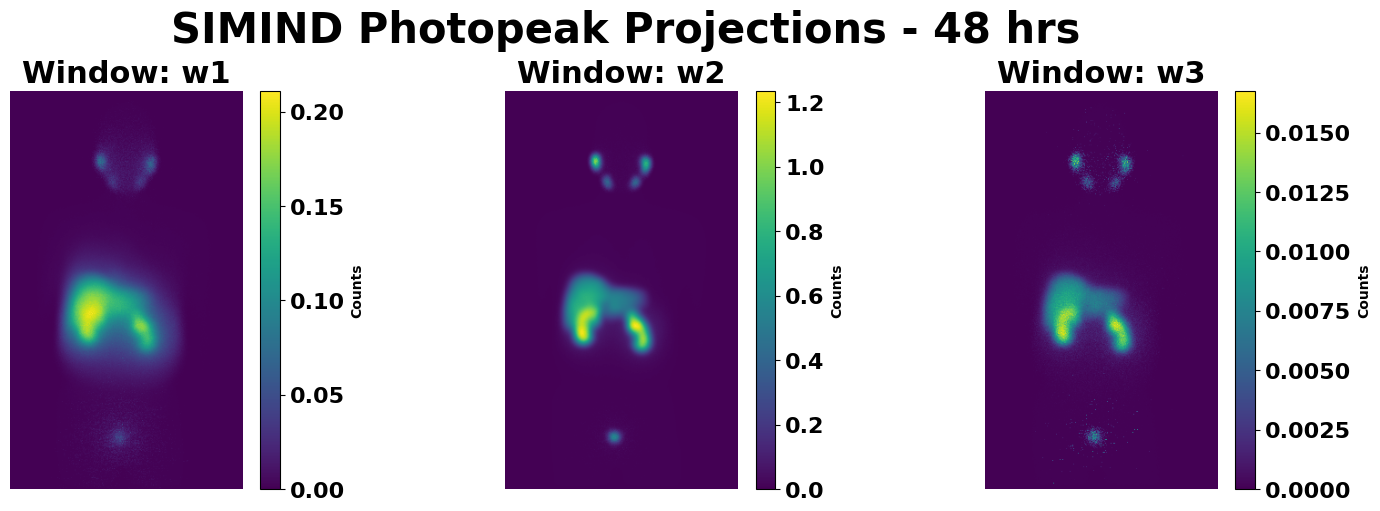

--- Frame: 77 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_4620min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_4620min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_4620min_tot_w3.a00


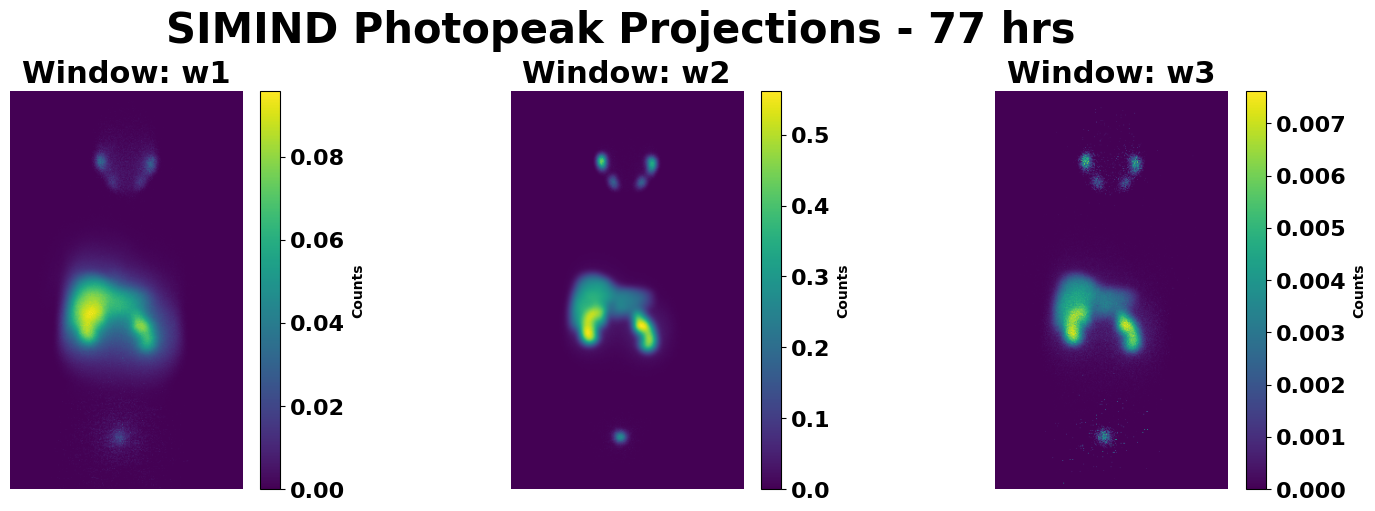

--- Frame: 156 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_9360min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_9360min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_9360min_tot_w3.a00


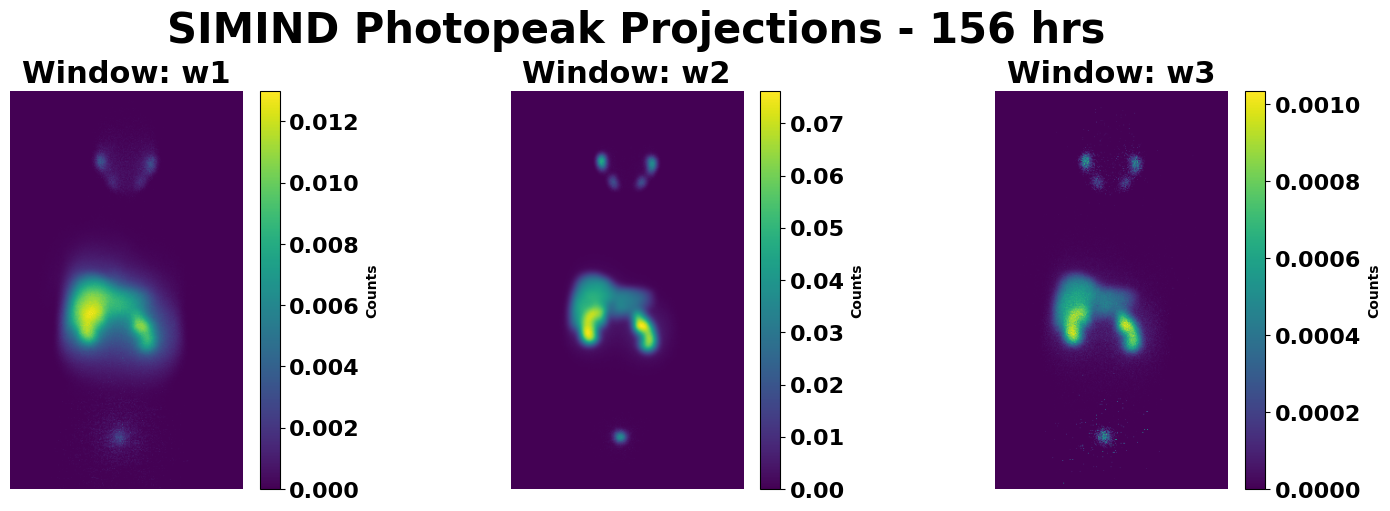

In [41]:
window = ['w1', 'w2', 'w3']
print("Plotting SIMIND projections for windows:", window)
print("NOTE: This is prior to any reconstruction step or poisson noise addition.")
for f in frames_start_times:
    print(f"--- Frame: {int(f/60)} hrs ---")
    figure, axes = plt.subplots(1, len(window), figsize=(5*len(window), 5), constrained_layout=True)
    for w in window:
        file_path = os.path.join(spect_sim_dir_path, f"{spect_sim_prefix}_{int(f)}min_tot_{w}.a00")
        print(f"Loading SIMIND projection from: {file_path}")
        
        photopeak = np.fromfile(file_path, dtype=np.float32)
        projections = (torch.tensor(photopeak.reshape(simind_shape)))
        
        # Plot projection
        projection_num = 0  # first projection
        im = axes[window.index(w)].imshow(projections[projection_num,:,:]) 
        figure.colorbar(im, ax=axes[window.index(w)], label='Counts')
        axes[window.index(w)].set_title(f'Window: {w}')
        axes[window.index(w)].axis('off')
    figure.suptitle(f'SIMIND Photopeak Projections - {int(f/60)} hrs', fontsize=30)
    plt.show()
    
    
    
    

#### SIMIND: Frame-Based Projection Plots  (with Possion Noise)

Plotting SIMIND projections for windows: ['w1', 'w2', 'w3']
NOTE: This is prior to any reconstruction step or poisson noise addition.
--- Frame: 2 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min_tot_w3.a00


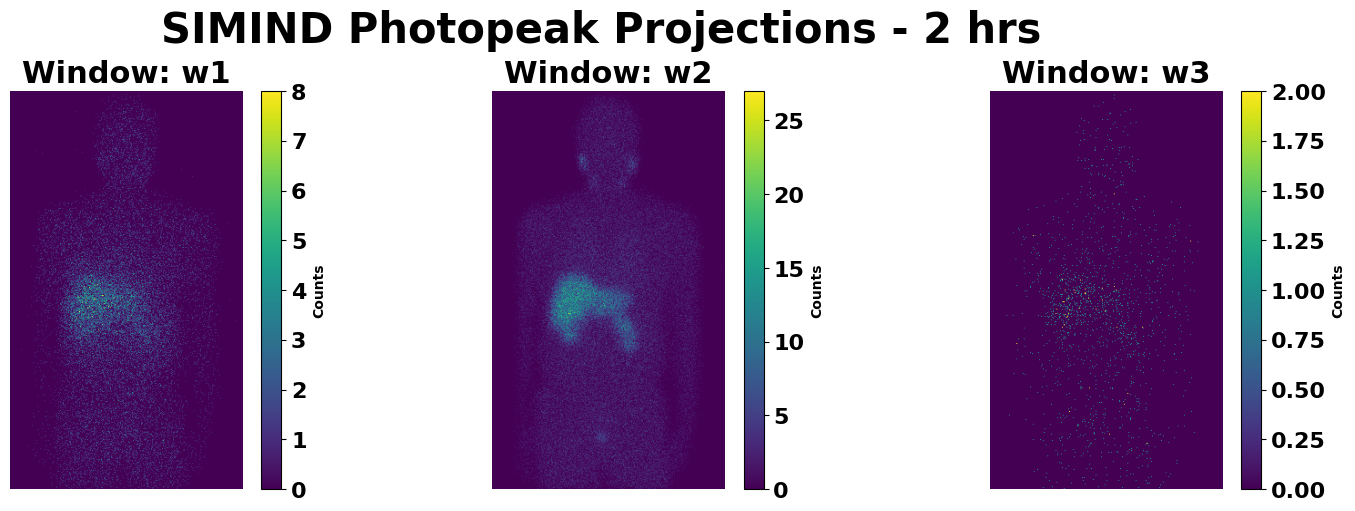

--- Frame: 24 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min_tot_w3.a00


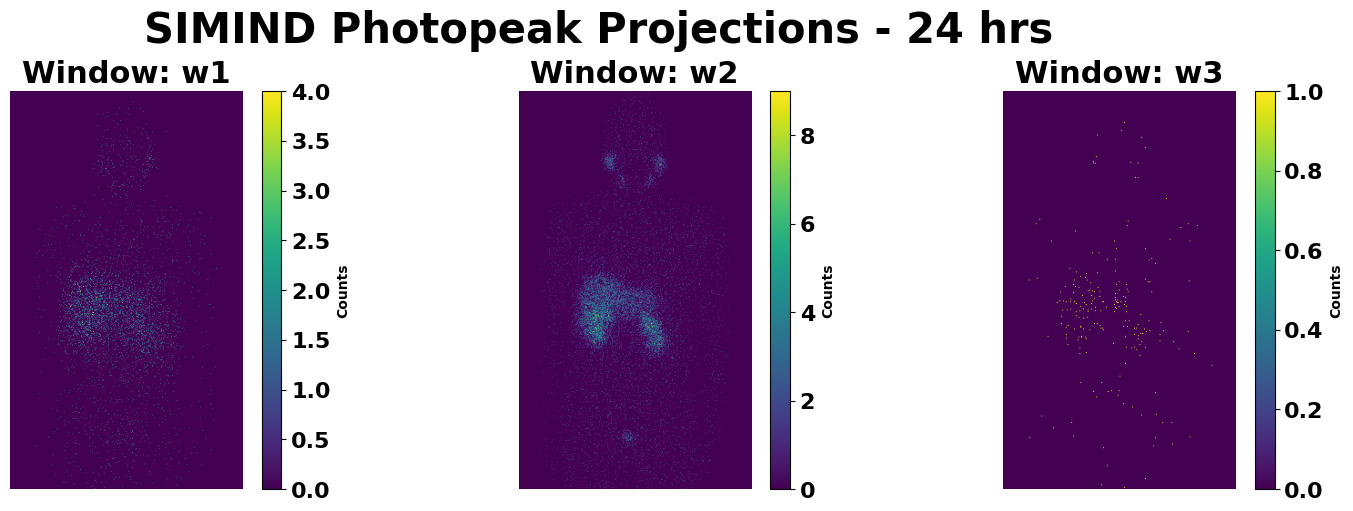

--- Frame: 48 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min_tot_w3.a00


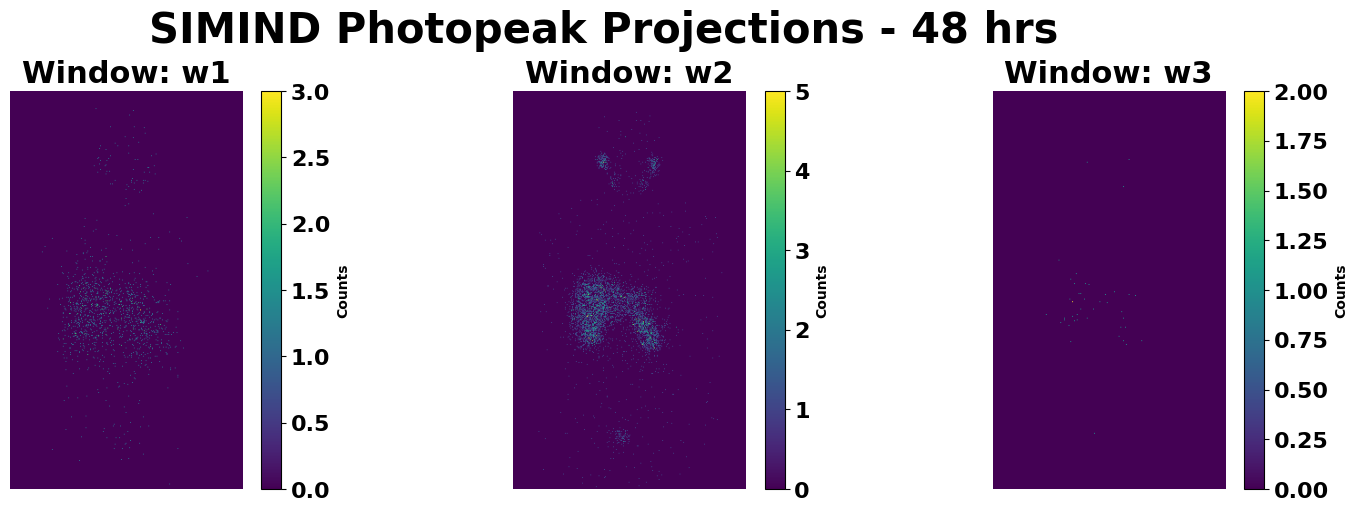

--- Frame: 77 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_4620min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_4620min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_4620min_tot_w3.a00


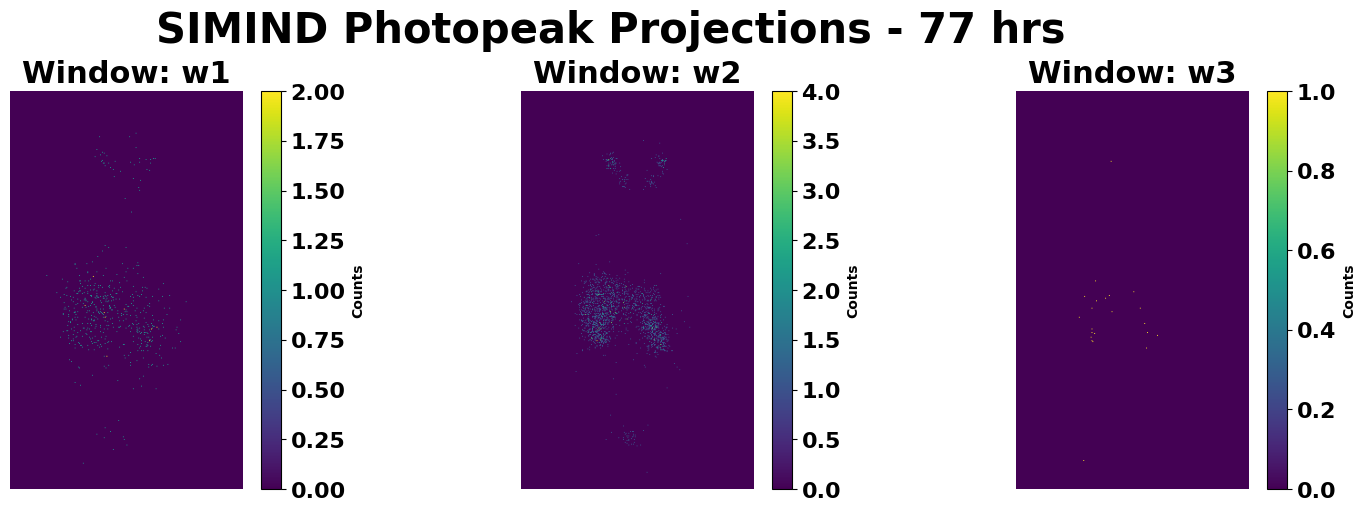

--- Frame: 156 hrs ---
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_9360min_tot_w1.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_9360min_tot_w2.a00
Loading SIMIND projection from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_9360min_tot_w3.a00


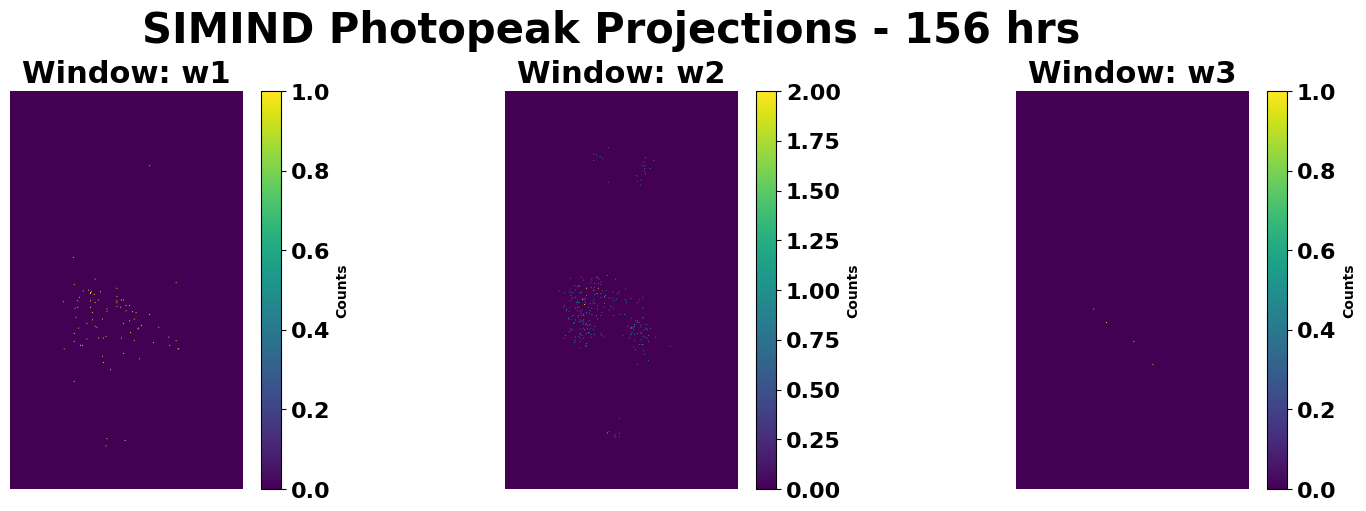

In [42]:
window = ['w1', 'w2', 'w3']
print("Plotting SIMIND projections for windows:", window)
print("NOTE: This is prior to any reconstruction step or poisson noise addition.")
for f in frames_start_times:
    print(f"--- Frame: {int(f/60)} hrs ---")
    figure, axes = plt.subplots(1, len(window), figsize=(5*len(window), 5), constrained_layout=True)
    for w in window:
        file_path = os.path.join(spect_sim_dir_path, f"{spect_sim_prefix}_{int(f)}min_tot_{w}.a00")
        print(f"Loading SIMIND projection from: {file_path}")
        
        # added poisson noise
        photopeak = np.fromfile(file_path, dtype=np.float32)
        projections = (torch.tensor(photopeak.reshape(simind_shape)))
        projections = torch.poisson(projections)
        
        # Plot projection
        projection_num = 0  # first projection
        im = axes[window.index(w)].imshow(projections[projection_num,:,:]) 
        figure.colorbar(im, ax=axes[window.index(w)], label='Counts')
        axes[window.index(w)].set_title(f'Window: {w}')
        axes[window.index(w)].axis('off')
    figure.suptitle(f'SIMIND Photopeak Projections - {int(f/60)} hrs', fontsize=30)
    plt.show()
    
    
    
    

## Reconstruction Stage

### Setup

In [43]:
spect_sim_dir_path = os.path.join(output_folder_path, config['subdir_names']['spect_simulation'])
print("Loading SPECT simulation outputs from:", spect_sim_dir_path)
spect_sim_prefix = config['spect_simulation']['name']

Loading SPECT simulation outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs


#### Plot Reconstructed SPECT Image 

Loading Attenuation Image Used in Reconstruction: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_atn_img.nii


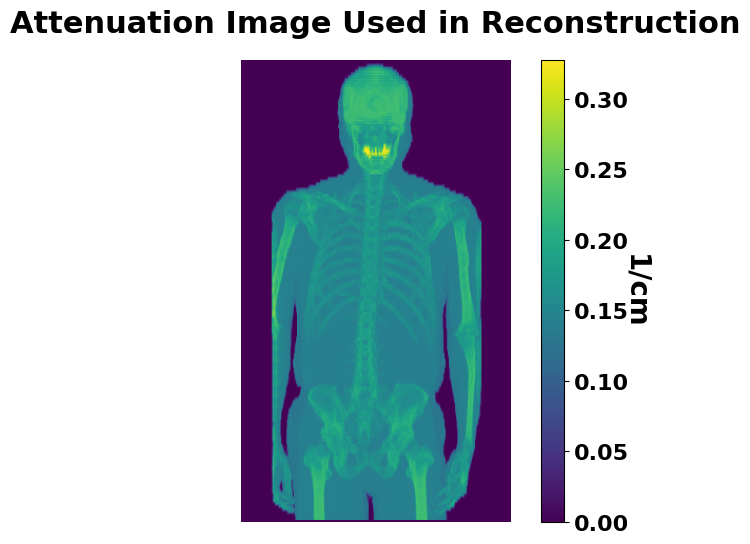

Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min.nii
Reconstructed volume shape: (439, 256, 256)
Reconstructed volume spacing: (0.25, 0.25, 0.25)
Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min.nii
Reconstructed volume shape: (439, 256, 256)
Reconstructed volume spacing: (0.25, 0.25, 0.25)
Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min.nii
Reconstructed volume shape: (439, 256, 256)
Reconstructed volume spacing: (0.25, 0.25, 0.25)
Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spe

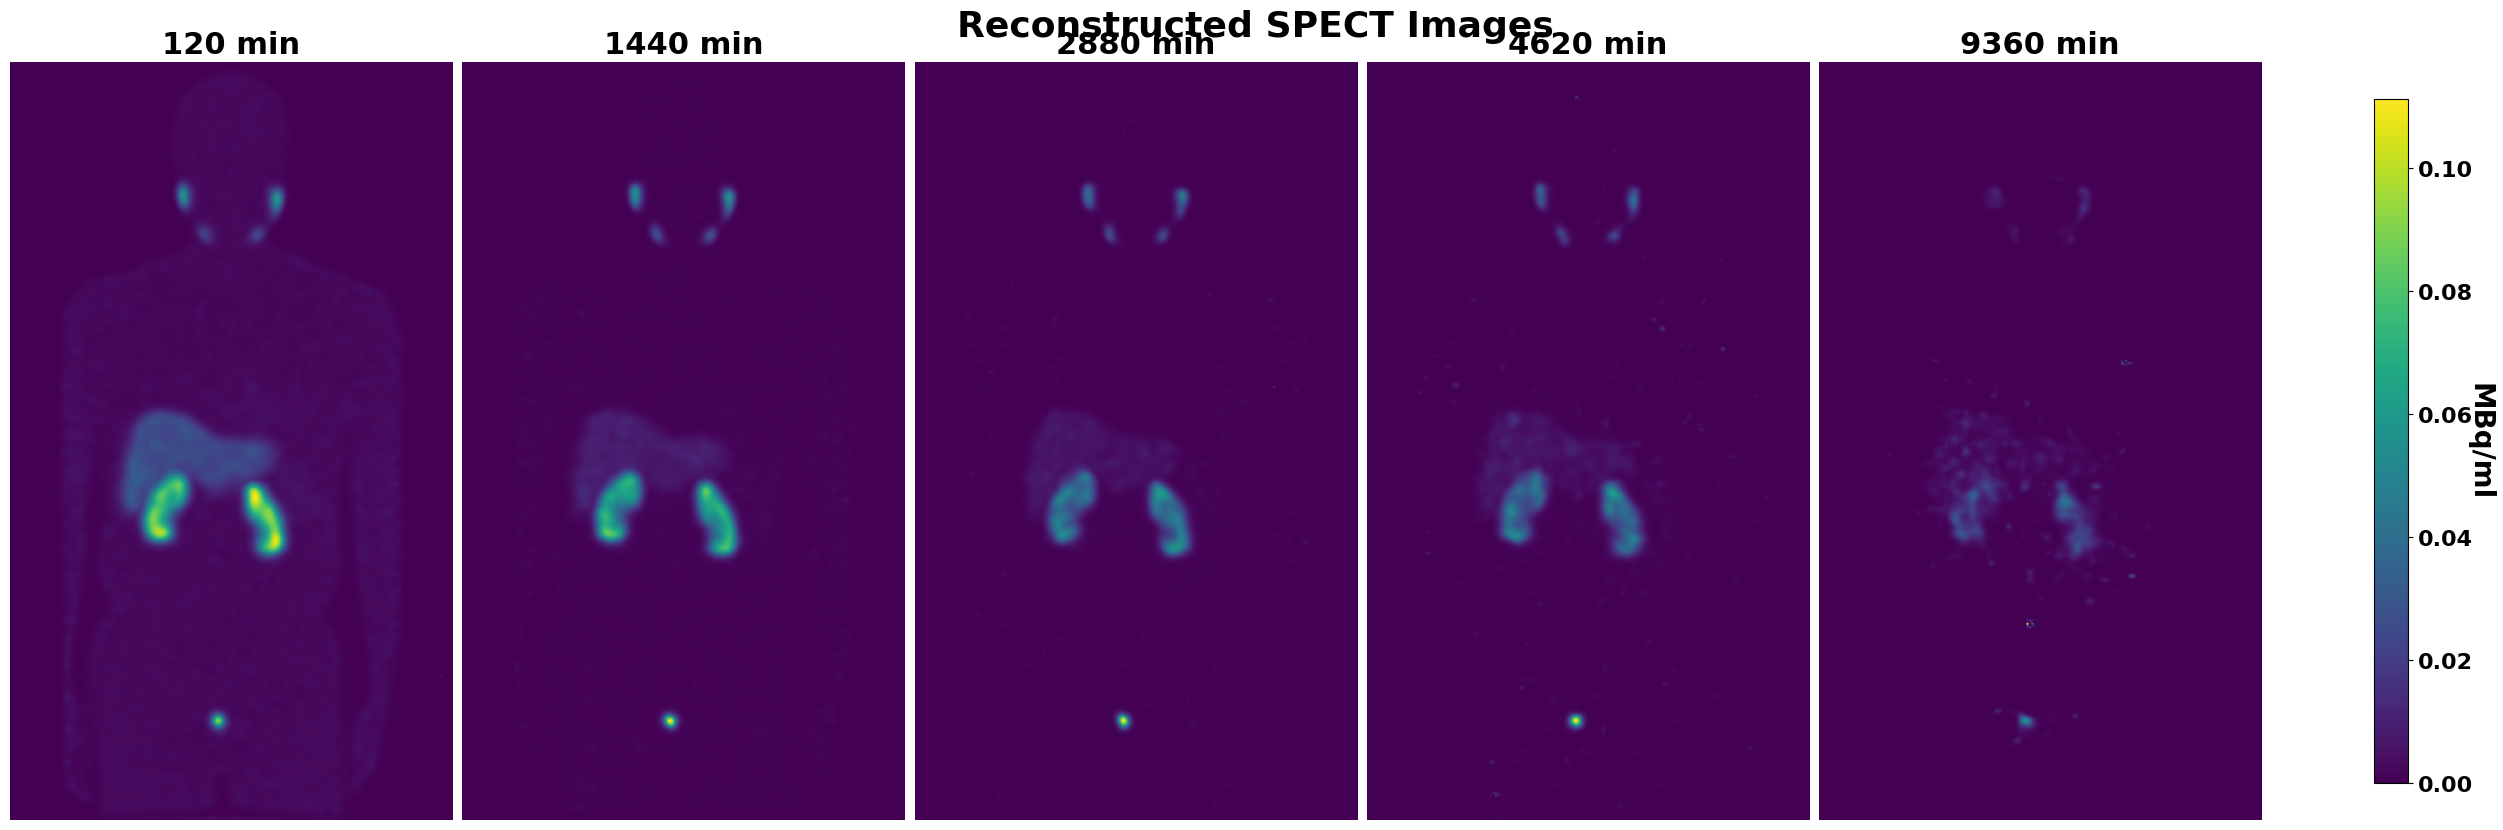

Reconstruction paths:
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min.nii
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min.nii
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min.nii
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_4620min.nii
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_9360min.nii


In [44]:
# Global styling (recommended)
# ----------------------------
mpl.rcParams.update({
    "font.size": 15,              # base size
    "font.weight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 22,
    "figure.titlesize": 26,
    "figure.titleweight": "bold",
    "axes.labelweight": "bold",
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

# --- Attenuation image ---
file_path = os.path.join(spect_sim_dir_path, f"{spect_sim_prefix}_atn_img.nii")
print(f"Loading Attenuation Image Used in Reconstruction: {file_path}")

atn_img = sitk.ReadImage(file_path)
atn = sitk.GetArrayFromImage(atn_img)  # (z,y,x)

plt.figure(figsize=(8, 6))
im = plt.imshow(np.max(atn[::-1], axis=1), cmap="viridis")
plt.title("Attenuation Image Used in Reconstruction", pad=20)
cbar = plt.colorbar(im)
cbar.set_label("1/cm", rotation=270, labelpad=15)  # change if you know different units
plt.axis("off")
plt.show()

# --- Recon frames ---
recon_paths = []
frames_start_times = config["pbpk"]["FrameStartTimes"]  # [min]

fig, ax = plt.subplots(1, len(frames_start_times),
                       figsize=(5 * len(frames_start_times), 8),
                       constrained_layout=True)
ax = np.atleast_1d(ax)

for indx, f in enumerate(frames_start_times):
    recon_path = os.path.join(spect_sim_dir_path, f"{spect_sim_prefix}_{int(f)}min.nii")
    recon_paths.append(recon_path)

    print(f"Loading reconstructed volume from: {recon_path}")
    recon_img = sitk.ReadImage(recon_path)
    recon = sitk.GetArrayFromImage(recon_img)  # (z,y,x)

    print(f"Reconstructed volume shape: {recon.shape}")
    print(f"Reconstructed volume spacing: {recon_img.GetSpacing()}")

    im = ax[indx].imshow(np.max(recon[::-1], axis=1), cmap="viridis")
    ax[indx].set_title(f"{f} min")
    ax[indx].axis("off")

# one shared colorbar for the whole subplot figure
cbar = fig.colorbar(im, ax=ax.tolist(), shrink=0.9)
cbar.set_label("MBq/ml", rotation=270, labelpad=15)  # if recon is activity concentration

plt.suptitle("Reconstructed SPECT Images", y=1.02)
plt.show()

print("Reconstruction paths:")
print("\n".join(recon_paths))

Loading Attenuation Image Used in Reconstruction: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_atn_img.nii


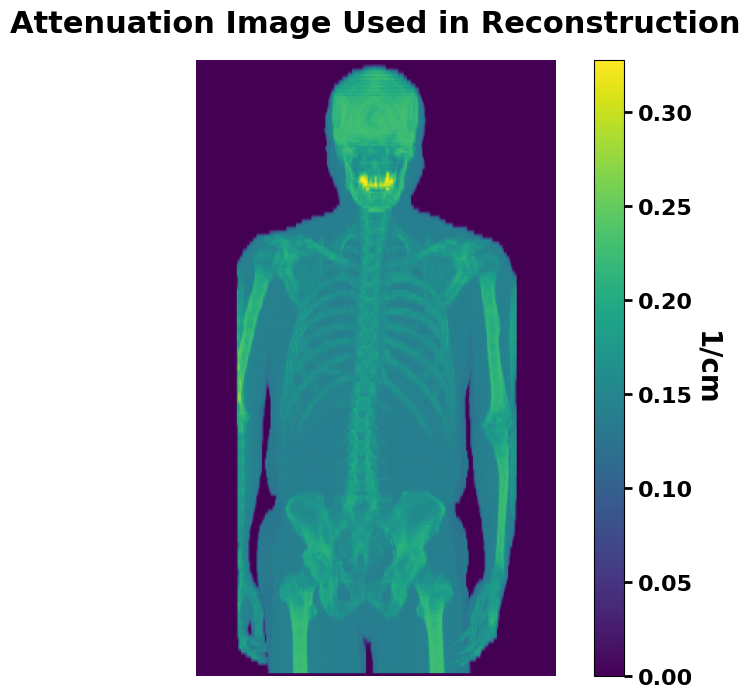

Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min.nii
Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min.nii
Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min.nii
Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_4620min.nii
Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_9360min.nii


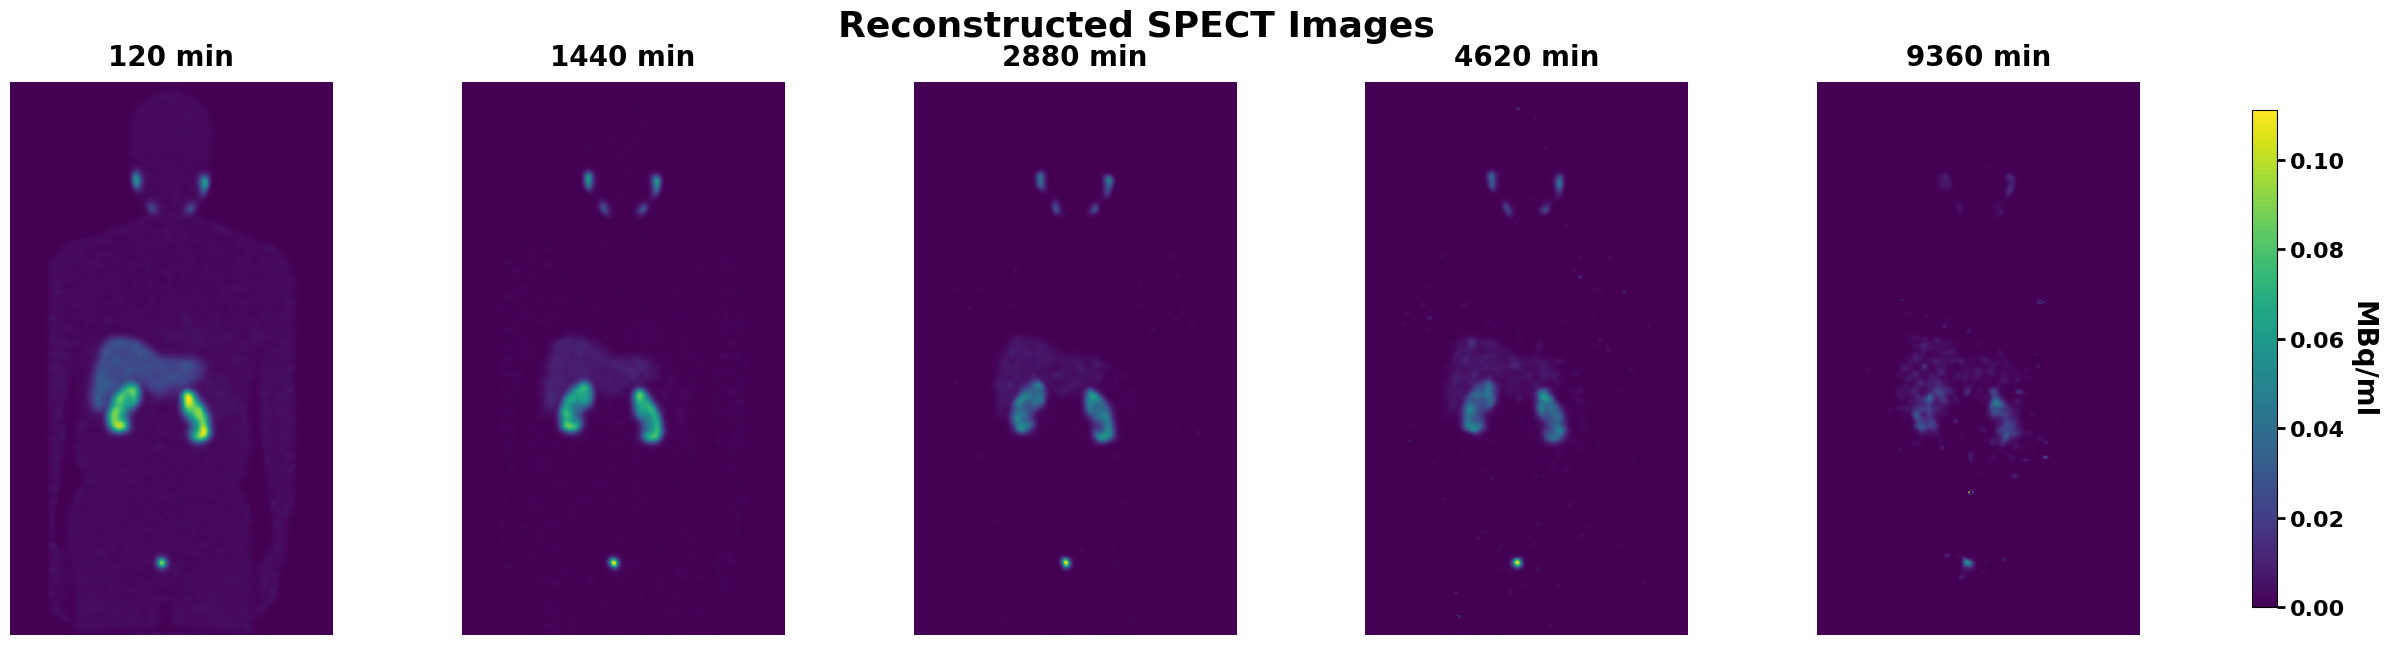

Reconstruction paths:
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_120min.nii
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_1440min.nii
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_2880min.nii
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_4620min.nii
/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/20_patient_dataset_feb_2026/TDT_Output__CT_1/spect_simulation_outputs/spect_simulation_9360min.nii


In [45]:


# --- Attenuation image ---
file_path = os.path.join(spect_sim_dir_path, f"{spect_sim_prefix}_atn_img.nii")
print(f"Loading Attenuation Image Used in Reconstruction: {file_path}")

atn_img = sitk.ReadImage(file_path)
atn = sitk.GetArrayFromImage(atn_img)  # (z,y,x)

plt.figure(figsize=(10, 8))
im = plt.imshow(np.max(atn[::-1], axis=1), cmap="viridis")

plt.title("Attenuation Image Used in Reconstruction", pad=20, fontweight="bold")
cbar = plt.colorbar(im)

# colorbar label + ticks bigger/bold
cbar.set_label("1/cm", rotation=270, labelpad=20, fontsize=20, fontweight="bold")
cbar.ax.tick_params(labelsize=16, width=2, length=6)
for t in cbar.ax.get_yticklabels():
    t.set_fontweight("bold")

plt.axis("off")
plt.show()

# --- Recon frames ---
recon_paths = []
frames_start_times = config["pbpk"]["FrameStartTimes"]  # [min]

fig, ax = plt.subplots(
    1, len(frames_start_times),
    figsize=(5 * len(frames_start_times), 6),
    constrained_layout=True
)
ax = np.atleast_1d(ax)

for indx, f in enumerate(frames_start_times):
    recon_path = os.path.join(spect_sim_dir_path, f"{spect_sim_prefix}_{int(f)}min.nii")
    recon_paths.append(recon_path)

    print(f"Loading reconstructed volume from: {recon_path}")
    recon_img = sitk.ReadImage(recon_path)
    recon = sitk.GetArrayFromImage(recon_img)  # (z,y,x)

    im = ax[indx].imshow(np.max(recon[::-1], axis=1), cmap="viridis")
    ax[indx].set_title(f"{f} min", fontsize=20, fontweight="bold", pad=12)
    ax[indx].axis("off")

# one shared colorbar for the whole subplot figure
cbar = fig.colorbar(im, ax=ax.tolist(), shrink=0.9)
cbar.set_label("MBq/ml", rotation=270, labelpad=22, fontsize=20, fontweight="bold")
cbar.ax.tick_params(labelsize=16, width=2, length=6)
for t in cbar.ax.get_yticklabels():
    t.set_fontweight("bold")

fig.suptitle("Reconstructed SPECT Images", y=1.05, fontsize=26, fontweight="bold")
plt.show()

print("Reconstruction paths:")
print("\n".join(recon_paths))

# SPECT Post Processing 

## Create Recon Images Masks + find Sampled TAC Values for RECON SPECT

### Load RECON images and Segmentated Body + ROI + Parameters needed

In [46]:
roi_body_seg_arr_old = roi_body_data.copy() # arr [z,y,x] (shape is different then recon)
shape_old = roi_body_seg_arr_old.shape
arr_px_spacing_cm_old = arr_px_spacing_cm # spacing [z,y,x] cm
print(f"Old ROI+Body seg shape: {shape_old} | spacing (cm): {arr_px_spacing_cm_old}")
old_vox_vol = arr_px_spacing_cm_old[0] * arr_px_spacing_cm_old[1] * arr_px_spacing_cm_old[2] # cm^3 = ml
print(f"Old voxel volume: {old_vox_vol} ml")

recon_paths = recon_paths.copy() 
recon_ref = sitk.ReadImage(recon_paths[0])
OutputImgSize = config['spect_simulation']['OutputImgSize'] # cm
OutputPixelWidth = config['spect_simulation']['OutputPixelWidth'] # cm
OutputSliceWidth = config['spect_simulation']['OutputSliceWidth']  # cm 
recon_shape = recon_ref.GetSize()  # (x, y, z)
recon_arr = sitk.GetArrayFromImage(recon_ref)  # [z, y, x]
print(f"Reconstructed Image shape (x,y,z): {recon_shape} | spacing (cm): {(OutputPixelWidth, OutputPixelWidth, OutputSliceWidth)}")
recon_vox_vol = OutputPixelWidth * OutputPixelWidth * OutputSliceWidth  # cm^3 = ml
print(f"Reconstructed voxel volume: {recon_vox_vol} ml")


Old ROI+Body seg shape: (168, 256, 256) | spacing (cm): (0.6539999961853028, 0.19531240463256838, 0.19531240463256838)
Old voxel volume: 0.024948095608275895 ml
Reconstructed Image shape (x,y,z): (256, 256, 439) | spacing (cm): (0.25, 0.25, 0.25)
Reconstructed voxel volume: 0.015625 ml


### Sample Segementaed data into Recon space ( so seg roi + body and recon spect images are 1:1) 

recon shape: (256, 256, 439) spacing: (0.25, 0.25, 0.25) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (-31.875, -31.875, -54.75)
seg shape: (256, 256, 168) spacing: (0.19531240463256838, 0.19531240463256838, 0.6539999961853028) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (-24.90233159065247, -24.90233159065247, -54.60899968147278)
[0 1 2 3 4 5 6 7]


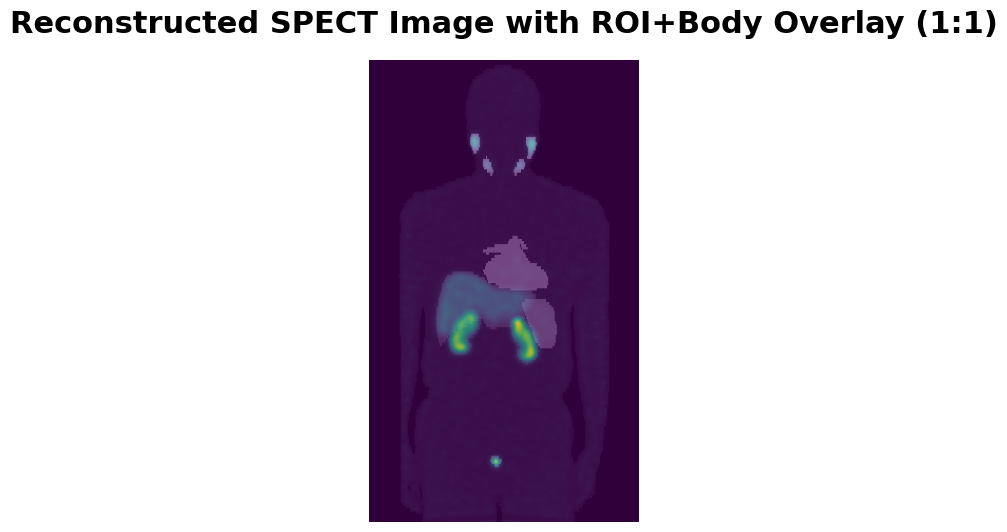

New ROI+Body seg shape: (439, 256, 256) | spacing (cm): (0.25, 0.25, 0.25)
New voxel volume: 0.015625 ml


In [47]:
def center_origin(img):
        size = np.array(img.GetSize(), dtype=float)   # (x,y,z)
        sp = np.array(img.GetSpacing(), dtype=float)  # (x,y,z)
        origin = -0.5 * (size - 1.0) * sp
        img.SetOrigin(tuple(origin.tolist()))
        img.SetDirection((1,0,0, 0,1,0, 0,0,1))
        return img


def resample_labels_to_recon_space(label_arr_zyx, spacing_zyx_cm, recon_ref_img):
        # label_arr is (z,y,x). SITK expects array in (z,y,x) for GetImageFromArray.
        seg_img = sitk.GetImageFromArray(label_arr_zyx.astype(np.int16))
        seg_img.SetSpacing(tuple(spacing_zyx_cm[::-1]))  # (x,y,z)
        seg_img.SetDirection((1,0,0, 0,1,0, 0,0,1))
        seg_img = center_origin(seg_img)

        recon_ref_img = center_origin(recon_ref_img)
        
        
        print("recon shape:", recon_ref_img.GetSize(),
              "spacing:", recon_ref_img.GetSpacing(),
              recon_ref_img.GetDirection(),
              recon_ref_img.GetOrigin())
        
        print("seg shape:", seg_img.GetSize(),
              "spacing:", seg_img.GetSpacing(),
              seg_img.GetDirection(),
              seg_img.GetOrigin())
        
        seg_in_recon = sitk.Resample(
            seg_img,
            recon_ref_img,                 # target grid
            sitk.Transform(),              # identity
            sitk.sitkNearestNeighbor,      # MUST for labels
            0,                             # background outside
            sitk.sitkInt16
        )
        seg_arr_recon_zyx = sitk.GetArrayFromImage(seg_in_recon).astype(np.int16)
        return seg_in_recon, seg_arr_recon_zyx, seg_in_recon.GetSpacing()

seg_img_recon, seg_arr_recon, seg_spacing_recon = resample_labels_to_recon_space(roi_body_seg_arr_old, arr_px_spacing_cm_old,recon_ref)
print(np.unique(seg_arr_recon))
# Example plot to show now is 1:1
plt.figure(figsize=(8, 6))
plt.imshow(np.max(recon_arr[::-1], axis=1), cmap='viridis')
plt.imshow(np.max(seg_arr_recon[::-1], axis=1), alpha=0.3, cmap='gray')
plt.title('Reconstructed SPECT Image with ROI+Body Overlay (1:1)', pad=20)
plt.axis('off')
plt.show()

# Print new spacing and voxel volume
shape_new = seg_arr_recon.shape
arr_px_spacing_cm_new = tuple(float(x) for x in seg_spacing_recon)
print(f"New ROI+Body seg shape: {shape_new} | spacing (cm): {arr_px_spacing_cm_new}")
new_vox_vol = arr_px_spacing_cm_new[0] * arr_px_spacing_cm_new[1] * arr_px_spacing_cm_new[2] # cm^3 = ml
print(f"New voxel volume: {new_vox_vol} ml")




### Build Masks 

Class segmentation map: {'body': 1, 'kidney': 2, 'liver': 3, 'prostate': 4, 'spleen': 5, 'heart': 6, 'salivary_glands': 7}
--- ROI: kidney ---


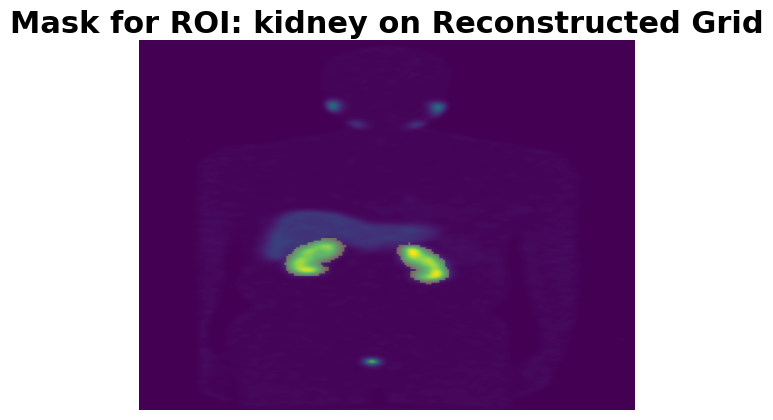

--- ROI: liver ---


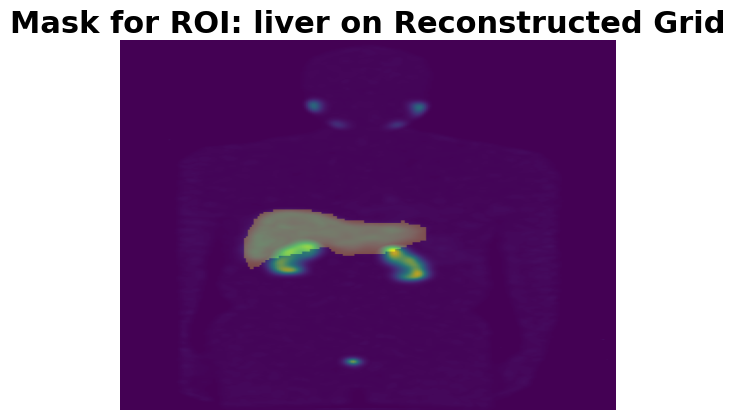

--- ROI: prostate ---


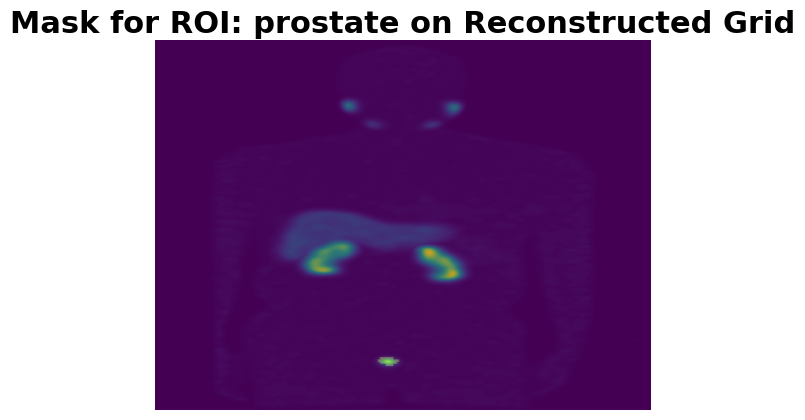

--- ROI: spleen ---


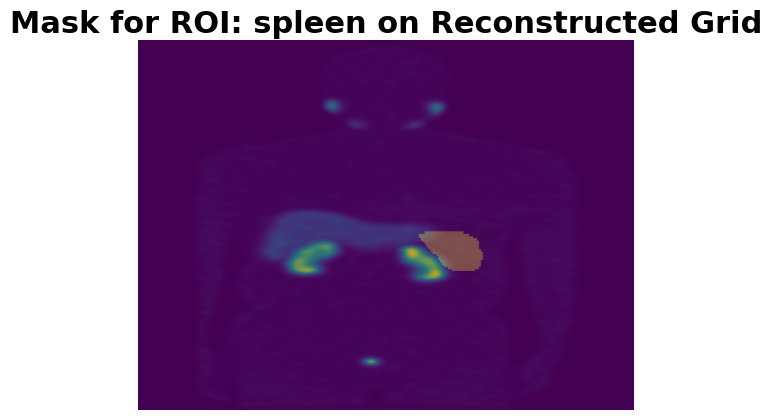

--- ROI: heart ---


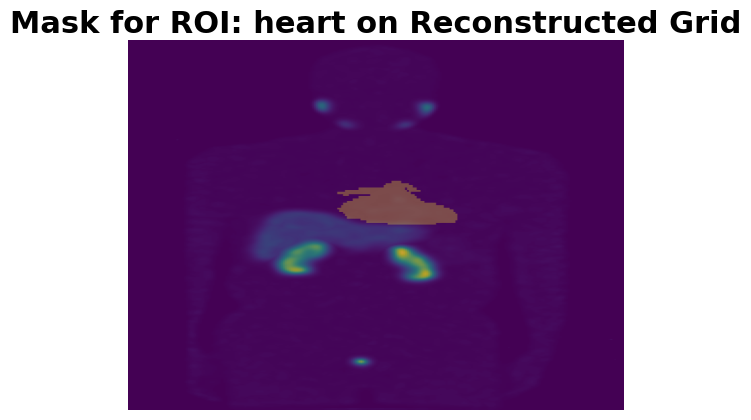

--- ROI: salivary_glands ---


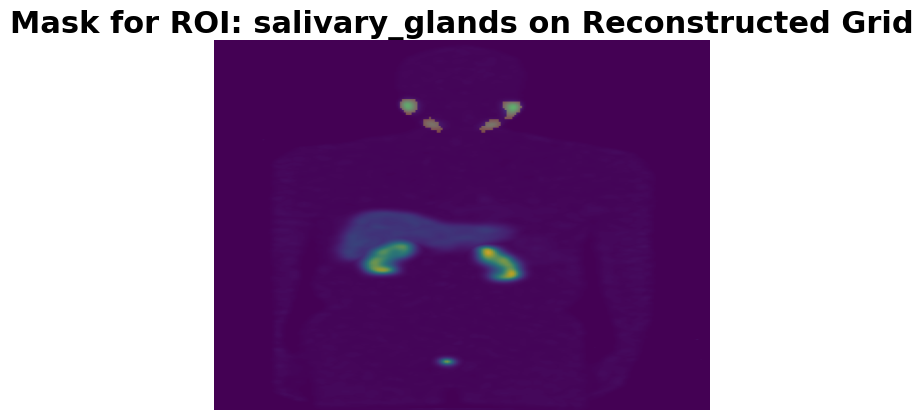

--- ROI: body ---


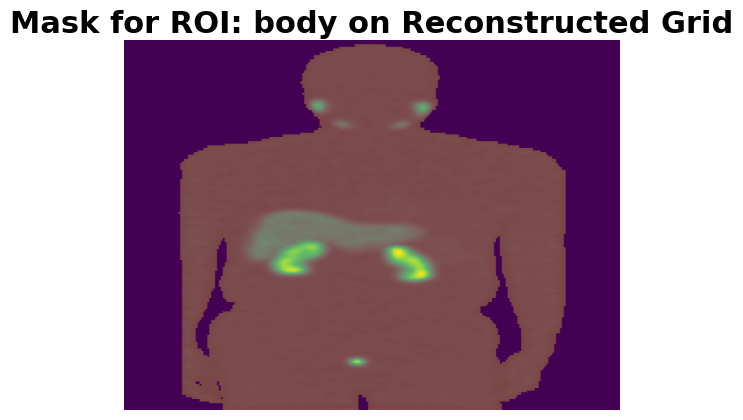

In [48]:
def build_masks_from_labels(label_arr_zyx, class_seg):
        # class_seg: {roi_name: label_value}
        return {roi: (label_arr_zyx == int(lab)) for roi, lab in class_seg.items()}
    
class_seg = class_map.copy()
print("Class segmentation map:", class_seg)

masks_recon = build_masks_from_labels(seg_arr_recon, class_seg)

# Plot masks on recon grid
for roi in roi_list:
        print(f"--- ROI: {roi} ---")
        mask = masks_recon.get(roi)
        plt.imshow(np.max(recon_arr[::-1], axis=1), cmap='viridis')
        plt.imshow(np.max(mask[::-1], axis=1), cmap="viridis", aspect='auto',alpha=0.3)
        plt.title(f"Mask for ROI: {roi} on Reconstructed Grid")
        plt.axis("off")
        plt.show()


### Calculate total activity within each ROI + Plot against PBPK TAC Curves

In [49]:
def roi_stats_from_frame(recon_arr_zyx, mask_zyx, recon_vox_vol):
        nvox = int(mask_zyx.sum())
        if nvox == 0:
            return np.nan, np.nan, 0

        # Sum of activity concentration over ROI voxels (MBq/mL * voxels)
        sum_conc = float(np.sum(recon_arr_zyx, where=mask_zyx)) # MBq/mL * voxels
        mean_conc = sum_conc / nvox               # MBq/mL
        total_mbq = sum_conc * recon_vox_vol       # MBq
        return mean_conc, total_mbq, nvox

def compute_spect_tac(recon_paths, masks_recon_space, recon_vox_vol):
        n_frames = len(recon_paths)

        # Pre-allocate outputs (cleaner than append+convert)
        sim_spect_tac = {
            roi: {
                "mean_mbq_per_ml": np.full(n_frames, np.nan, dtype=np.float32),
                "sum_mbq": np.full(n_frames, np.nan, dtype=np.float32),
                "nvox": np.zeros(n_frames, dtype=np.int32),
            }
            for roi in masks_recon_space
        }

        for i, recon_path in enumerate(recon_paths):
            recon_arr = sitk.GetArrayFromImage(sitk.ReadImage(recon_path)).astype(np.float32)  # (z,y,x)

            for roi, mask in masks_recon_space.items():
                mean_c, total_mbq, nvox = roi_stats_from_frame(recon_arr, mask, recon_vox_vol)
                sim_spect_tac[roi]["mean_mbq_per_ml"][i] = mean_c
                sim_spect_tac[roi]["sum_mbq"][i] = total_mbq
                sim_spect_tac[roi]["nvox"][i] = nvox

        return sim_spect_tac
    
sim_spect_tac = compute_spect_tac(recon_paths, masks_recon, recon_vox_vol)
    
print("SPECT Simulated TAC Results:")
for roi in sim_spect_tac:
    print(f"--- ROI: {roi} ---")

    # write in scientific notation for easier reading
    print("Mean Activity Concentration (MBq/mL):", [f"{float(val):.4e}" for val in sim_spect_tac[roi]["mean_mbq_per_ml"]])
    print("Total Activity (MBq):", [f"{float(val):.4e}" for val  in sim_spect_tac[roi]["sum_mbq"]])

SPECT Simulated TAC Results:
--- ROI: body ---
Mean Activity Concentration (MBq/mL): ['3.0763e-02', '3.7247e-03', '8.6030e-04', '3.5158e-04', '4.8845e-05']
Total Activity (MBq): ['1.7817e+03', '2.1572e+02', '4.9827e+01', '2.0363e+01', '2.8290e+00']
--- ROI: kidney ---
Mean Activity Concentration (MBq/mL): ['7.1954e-01', '3.4216e-01', '1.5646e-01', '7.3624e-02', '1.0514e-02']
Total Activity (MBq): ['2.7810e+02', '1.3225e+02', '6.0471e+01', '2.8456e+01', '4.0637e+00']
--- ROI: liver ---
Mean Activity Concentration (MBq/mL): ['2.8638e-01', '5.5420e-02', '2.2911e-02', '1.1010e-02', '1.5529e-03']
Total Activity (MBq): ['4.9229e+02', '9.5266e+01', '3.9385e+01', '1.8927e+01', '2.6695e+00']
--- ROI: prostate ---
Mean Activity Concentration (MBq/mL): ['7.3097e-01', '4.4658e-01', '2.8443e-01', '1.4613e-01', '2.3411e-02']
Total Activity (MBq): ['2.9810e+00', '1.8212e+00', '1.1599e+00', '5.9592e-01', '9.5474e-02']
--- ROI: spleen ---
Mean Activity Concentration (MBq/mL): ['5.8513e-02', '9.3604e-03

## Validation Study 

### 1) Compare PBPK TAC Sampled Values (Ground Truth) vs RECON SPECT TAC Sampled Values

#### Plot PBPK TAC Sampled Values vs Simulated SPECT Sampled Values

/home/jhubadmin/miniconda3/envs/TDT_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/jhubadmin/miniconda3/envs/TDT_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


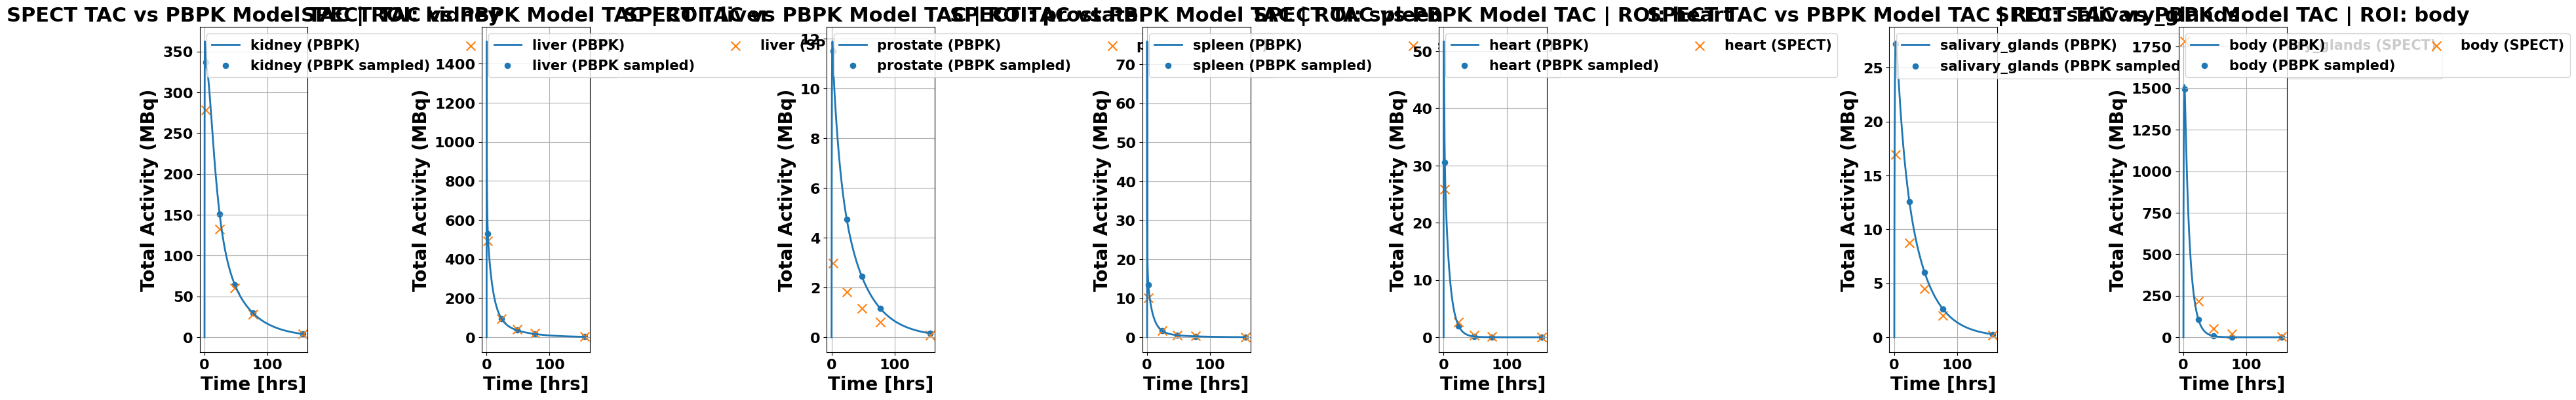

In [50]:
# plot SPECT TAC vs PBPK expected
figure , axes = plt.subplots(1, len(rois), figsize=(5*len(rois), 6), constrained_layout=True)
for indx,roi in enumerate(rois):
    roi = roi.lower()
    t_file = os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{roi}_TAC_time.bin")
    t, act, t_s, act_s = load_tac_bins(roi)
    spect_sum_vals = sim_spect_tac[roi]["sum_mbq"]
        
    # plots
    axes[indx].plot(t/60, act, linewidth=2, label=f"{roi} (PBPK)")
    axes[indx].scatter(t_s/60, act_s, s=35, label=f"{roi} (PBPK sampled)")
    axes[indx].scatter([f/60 for f in frames_start_times], spect_sum_vals, s=100, marker='x', label=f"{roi} (SPECT)")
    
    axes[indx].set_title(f"SPECT TAC vs PBPK Model TAC | ROI: {roi}")
    axes[indx].set_xlabel("Time [hrs]")
    axes[indx].set_ylabel("Total Activity (MBq)")
    axes[indx].grid()
    axes[indx].legend(ncol=2)  # makes legend less tall if many ROIs



#### Analysis on Difference + Error%

Note heart or certain organs might have wrong values due to partial volume effect spill in!

In [51]:
# ------- COMPARE SPECT TAC VS PBPK TAC -------

# Compute SPECT TAC once
spect_tac = compute_spect_tac(recon_paths, masks_recon, recon_vox_vol)

frames_start_times = np.array(frames_start_times, dtype=float)  # [min]

t_hr = frames_start_times / 60.0
n_frames = len(frames_start_times)

eps = 1e-12  # for safe percent error when PBPK ~ 0

error_percent = {}

for roi in rois:
    roi_key = roi.lower()
    if roi_key not in spect_tac:
        print(f"\n[WARN] ROI '{roi_key}' not found in spect_tac keys. Skipping.")
        continue

    # ---- PBPK sampled at frame times (preferred) ----
    t, act, t_s, act_s = load_tac_bins(roi_key, base_path=pbpk_dir_path, pbpk_prefix=pbpk_prefix)
    pbpk_at_frames = np.asarray(act_s, dtype=float)

    # ---- SPECT series ----
    spect_sum_mbq = np.asarray(spect_tac[roi_key]["sum_mbq"], dtype=float)
    spect_mean_mbq_ml = np.asarray(spect_tac[roi_key]["mean_mbq_per_ml"], dtype=float)
    nvox = np.asarray(spect_tac[roi_key]["nvox"], dtype=int)

    # ---- Differences ----
    diff_mbq = spect_sum_mbq - pbpk_at_frames

    # percent error = 100 * (SPECT - PBPK) / PBPK, but nan when PBPK ~ 0
    pct_err = np.full(diff_mbq.shape, np.nan, dtype=float)
    valid = np.abs(pbpk_at_frames) > eps
    pct_err[valid] = 100.0 * diff_mbq[valid] / pbpk_at_frames[valid]
    error_percent[roi_key] = pct_err

    # ============================
    # Per-ROI table
    # ============================
    print("\n" + "=" * 90)
    print(f"ROI: {roi_key}")
    print("=" * 90)

    hdr = (
        f"{'Frame':>5} | {'t(hr)':>6} | {'SPECT(MBq)':>12} | {'PBPK(MBq)':>11} | "
        f"{'Diff(MBq)':>11} | {'%Err':>8} | {'Mean(MBq/mL)':>12} | {'nvox':>7}"
    )
    print(hdr)
    print("-" * len(hdr))

    for i in range(n_frames):
        print(
            f"{i:5d} | {t_hr[i]:6.2f} | {spect_sum_mbq[i]:12.4f} | {pbpk_at_frames[i]:11.4f} | "
            f"{diff_mbq[i]:11.4f} | {pct_err[i]:8.2f} | {spect_mean_mbq_ml[i]:12.4f} | {nvox[i]:7d}"
        )





ROI: kidney
Frame |  t(hr) |   SPECT(MBq) |   PBPK(MBq) |   Diff(MBq) |     %Err | Mean(MBq/mL) |    nvox
---------------------------------------------------------------------------------------------
    0 |   2.00 |     278.1036 |    336.4990 |    -58.3954 |   -17.35 |       0.7195 |   24736
    1 |  24.00 |     132.2465 |    150.8228 |    -18.5763 |   -12.32 |       0.3422 |   24736
    2 |  48.00 |      60.4712 |     64.4615 |     -3.9903 |    -6.19 |       0.1565 |   24736
    3 |  77.00 |      28.4555 |     29.4718 |     -1.0163 |    -3.45 |       0.0736 |   24736
    4 | 156.00 |       4.0637 |      3.9989 |      0.0649 |     1.62 |       0.0105 |   24736

ROI: liver
Frame |  t(hr) |   SPECT(MBq) |   PBPK(MBq) |   Diff(MBq) |     %Err | Mean(MBq/mL) |    nvox
---------------------------------------------------------------------------------------------
    0 |   2.00 |     492.2903 |    530.9000 |    -38.6098 |    -7.27 |       0.2864 |  110016
    1 |  24.00 |      95.2665 |    

In [52]:
# testing script
roi = ["kidney", "liver", "salivary_glands"]
for r in roi:
    print(r)
    print(error_percent[r])

kidney
[-17.35381448 -12.31662752  -6.19024365  -3.44832987   1.62258453]
liver
[-7.27251271  1.93679442  9.16016878 15.33219787 19.88940994]
salivary_glands
[-37.62142704 -30.34001322 -25.50432402 -24.46890062 -29.94548846]


#### Plot of Error % vs Frame for each ROI

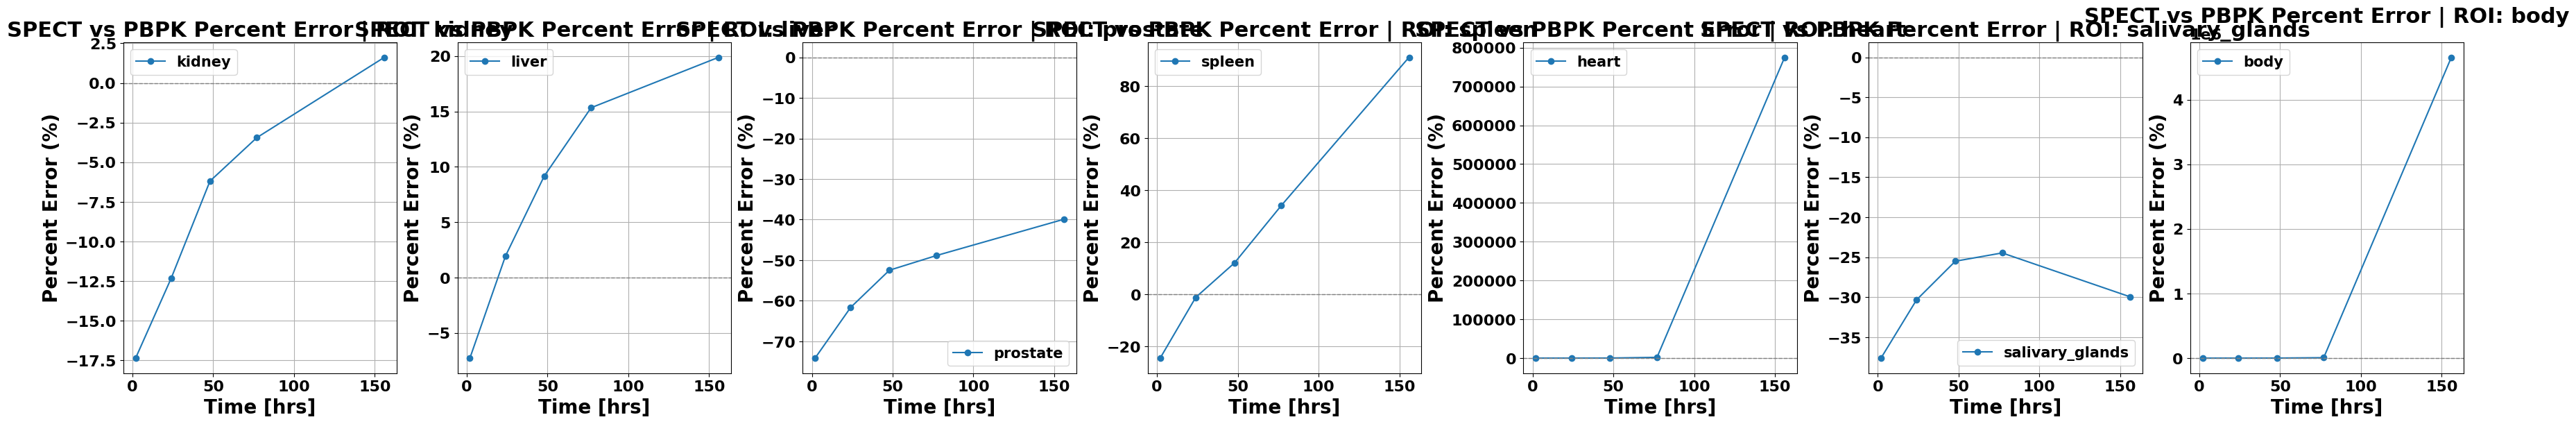

In [53]:
# plot of error% vs frames for each roi 
figure , axes = plt.subplots(1, len(rois), figsize=(5*len(rois), 6), constrained_layout=True)
for indx,roi in enumerate(rois):
    roi = roi.lower()
    pct_err = error_percent.get(roi)
    if pct_err is None:
        print(f"\n[WARN] ROI '{roi}' not found in error_percent keys. Skipping.")
        continue
    
    ax = axes[indx]
    ax.plot(t_hr, pct_err, marker='o', linestyle='-', label=f"{roi}")
    ax.set_title(f"SPECT vs PBPK Percent Error | ROI: {roi}")
    ax.set_xlabel("Time [hrs]")
    ax.set_ylabel("Percent Error (%)")
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.grid()
    ax.legend()


## 2) Observing kinetics of SPECT TAC Curve

### Applying Bi-Exponential Fit  + Find Parameters  

#### Raw Data TAC

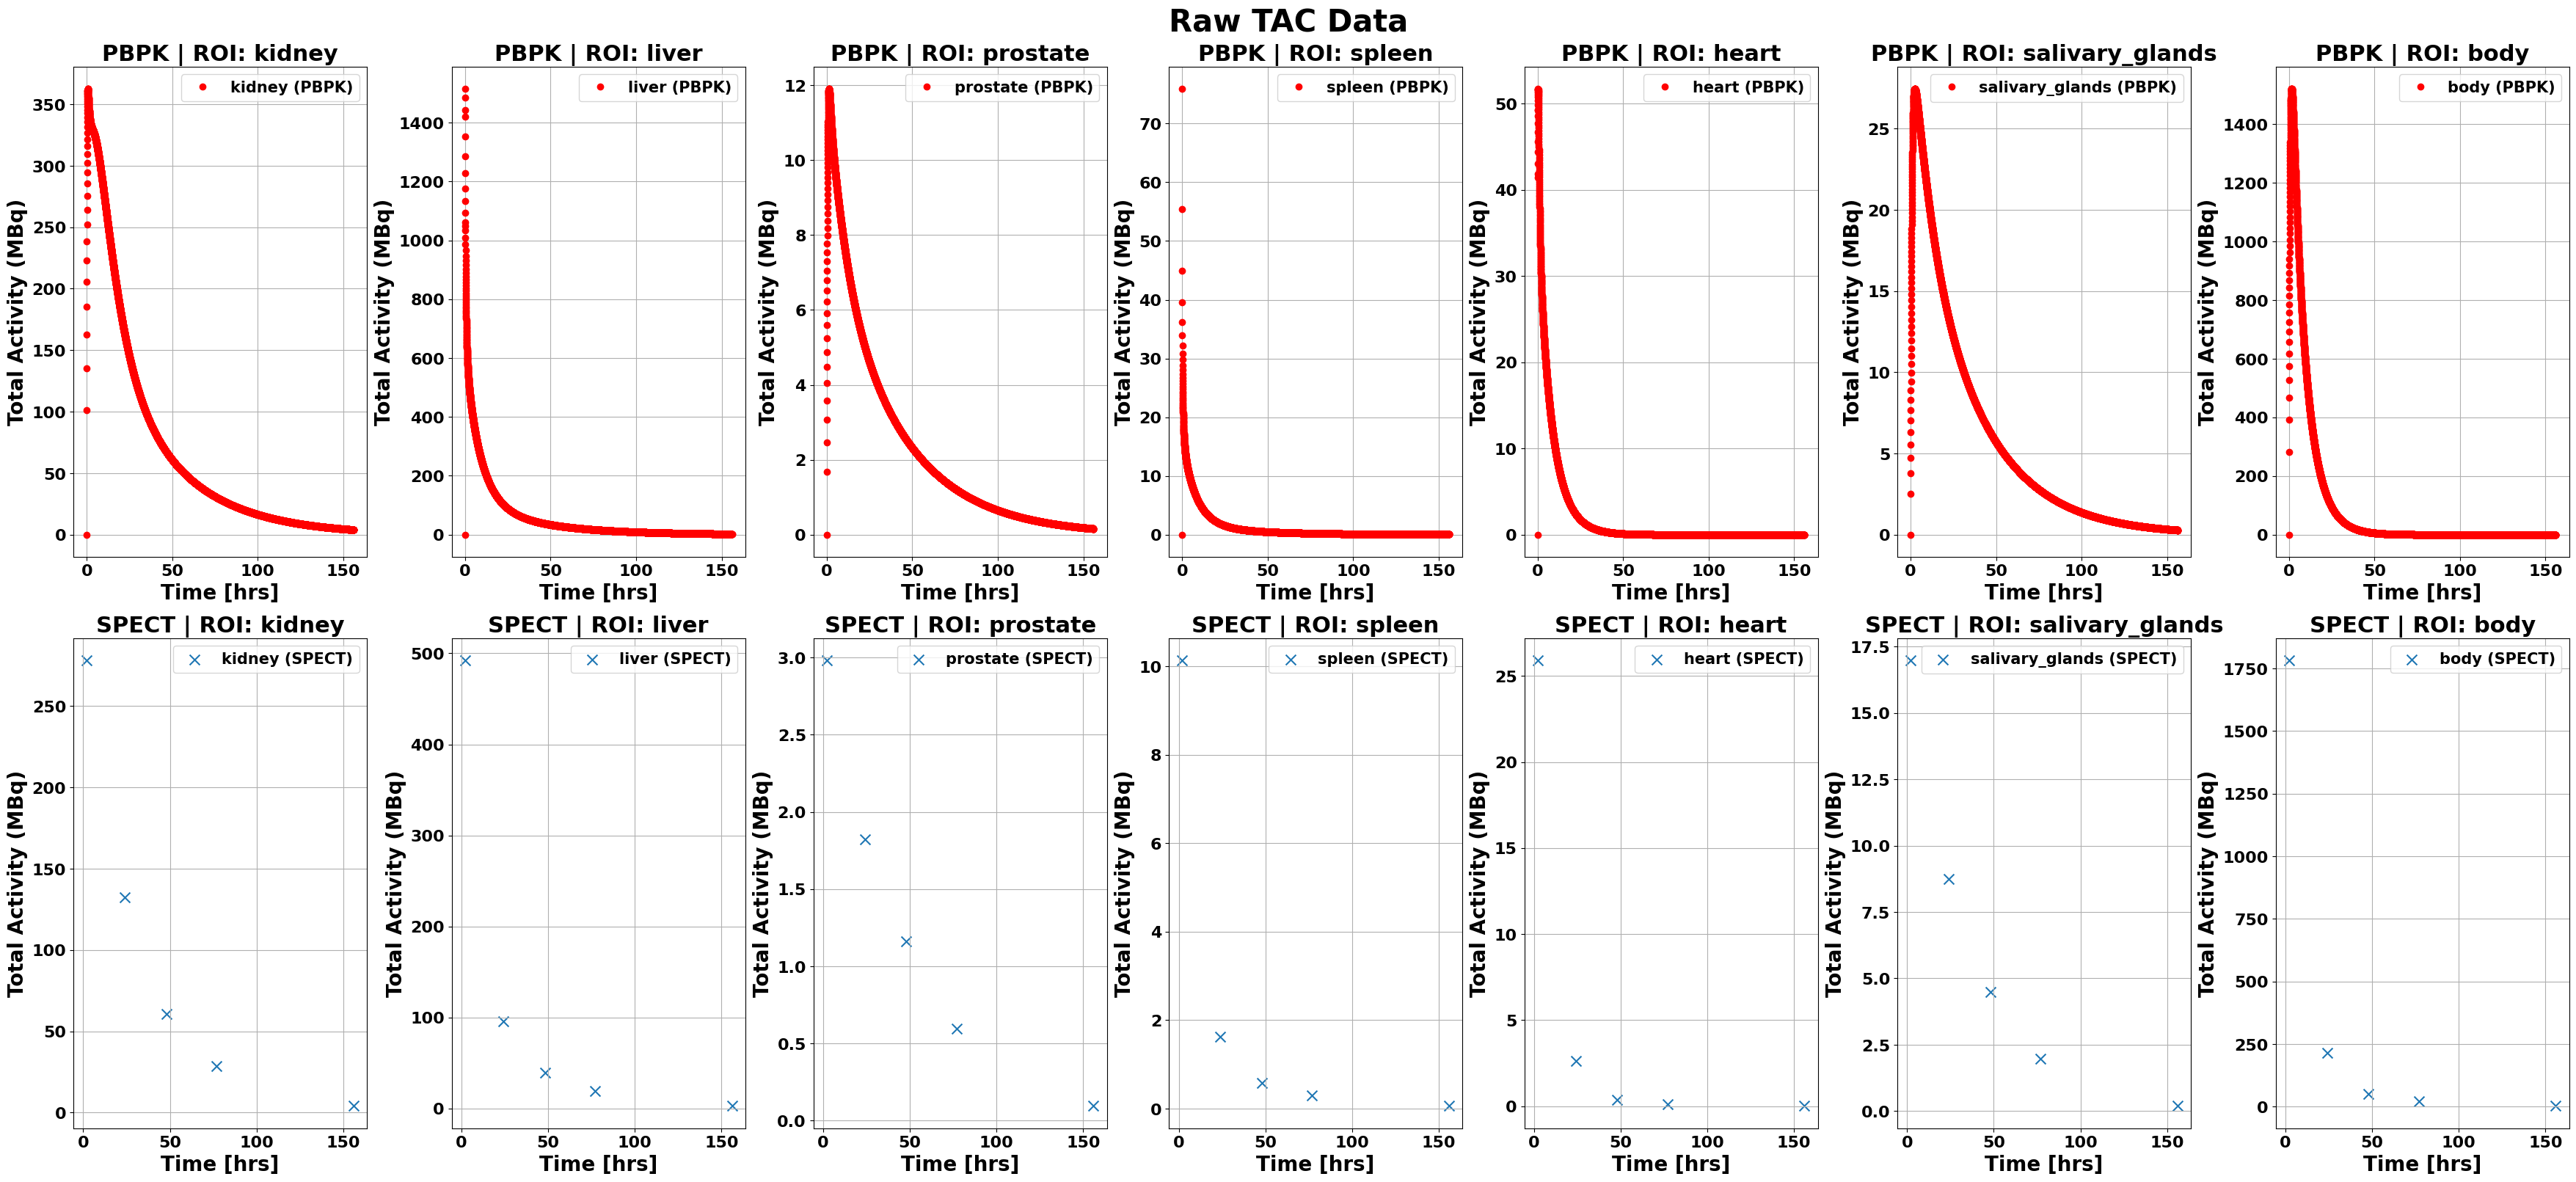

In [54]:
figure, axes = plt.subplots(2, len(rois), figsize=(5*len(rois), 16), constrained_layout=True)
figure.suptitle("Raw TAC Data", fontsize=30)
for roi in rois:
    roi = roi.lower()
    t_file = os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{roi}_TAC_time.bin")
    
    t, act, t_s, act_s = load_tac_bins(roi)
    axes[0, rois.index(roi)].plot(t/60, act, "ro",linewidth=2, label=f"{roi} (PBPK)")
    axes[0, rois.index(roi)].legend()
    axes[0, rois.index(roi)].set_xlabel("Time [hrs]")
    axes[0, rois.index(roi)].set_ylabel("Total Activity (MBq)")
    axes[0, rois.index(roi)].set_title(f"PBPK | ROI: {roi}")
    axes[0, rois.index(roi)].grid()
    
    spect_sum_vals = sim_spect_tac[roi]["sum_mbq"]
    axes[1, rois.index(roi)].scatter([f/60 for f in frames_start_times], spect_sum_vals, s=100, marker='x', label=f"{roi} (SPECT)")
    axes[1, rois.index(roi)].legend()
    axes[1, rois.index(roi)].set_xlabel("Time [hrs]")
    axes[1, rois.index(roi)].set_ylabel("Total Activity (MBq)")
    axes[1, rois.index(roi)].set_title(f"SPECT | ROI: {roi}")
    axes[1, rois.index(roi)].grid()
    
    
    

#### Bi Exponential funciton 

In [55]:
def biexp_through_origin(t, A, k_slow, delta):
    """
    y(t) = A*(exp(-k_slow*t) - exp(-(k_slow+delta)*t))
    - y(0)=0 always
    - k_fast = k_slow + delta >= k_slow
    """
    t = np.asarray(t, dtype=float)
    k_fast = k_slow + delta
    return A * (np.exp(-k_slow*t) - np.exp(-k_fast*t))

def _fit_biexp_through_origin(t, y):
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)

    mask = np.isfinite(t) & np.isfinite(y)
    t_fit = t[mask]
    y_fit = y[mask]

    if t_fit.size < 3:
        raise ValueError(f"Need >= 3 points for through-origin biexp (got {t_fit.size}).")

    Amax = float(np.max(y_fit))
    # reasonable initial guesses (t in hours)
    p0 = [Amax, 0.05, 1.0]  # A, k_slow, delta  (1/hr)
    bounds = ([0.0, 0.0, 0.0], [np.inf, np.inf, np.inf])

    popt, pcov = curve_fit(
        biexp_through_origin, t_fit, y_fit,
        p0=p0, bounds=bounds, maxfev=50000
    )

    yhat = biexp_through_origin(t_fit, *popt)
    rmse = float(np.sqrt(np.mean((yhat - y_fit)**2)))
    return popt, pcov, rmse, t_fit, y_fit

#### Fit function to both plots

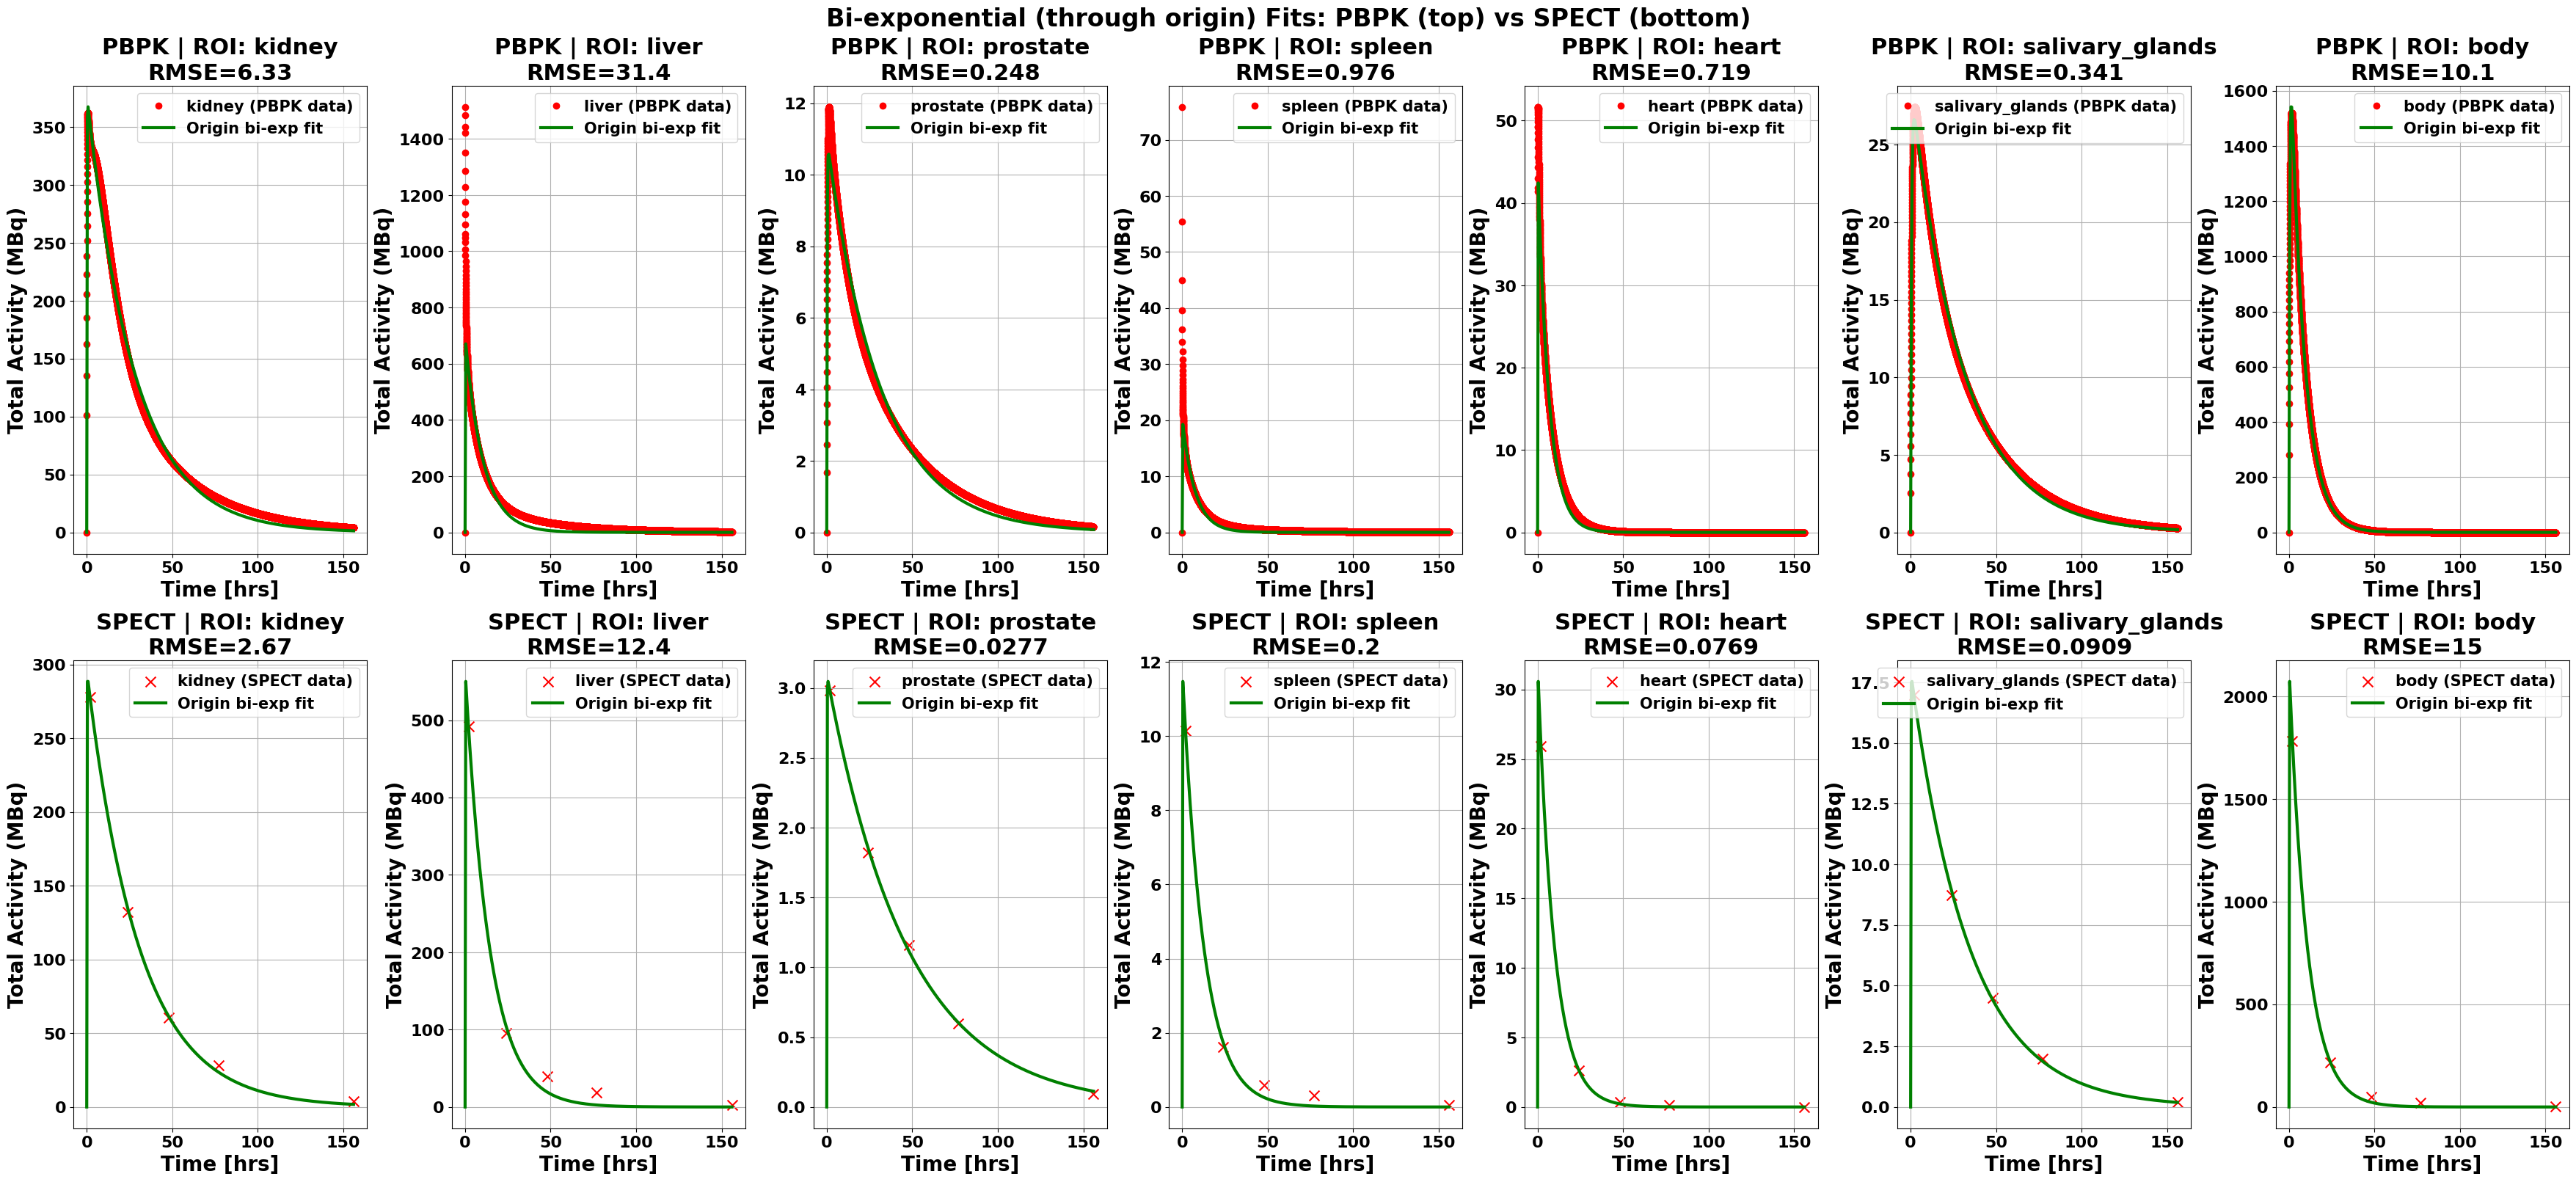

Bi-exponential Fit Results (through origin):









In [ ]:
n = len(rois)
fig, axes = plt.subplots(2, n, figsize=(5 * n, 16), constrained_layout=True)
fig.suptitle("Bi-exponential (through origin) Fits: PBPK (top) vs SPECT (bottom)", fontsize=24)

axes = np.array(axes)
if axes.ndim == 1:
    axes = axes.reshape(2, 1)

fit_results = {}

for j, roi_raw in enumerate(rois):
    roi_key = roi_raw.lower()

    # ---------- PBPK ----------
    t, act, t_s, act_s = load_tac_bins(roi_key)
    t_pbpk_hr = np.asarray(t, dtype=float) / 60.0
    y_pbpk = np.asarray(act, dtype=float)

    popt_pbpk, pcov_pbpk, rmse_pbpk, tfit_pbpk, yfit_pbpk = _fit_biexp_through_origin(t_pbpk_hr, y_pbpk)
    tgrid_pbpk = np.linspace(0.0, np.max(tfit_pbpk), 400)
    ygrid_pbpk = biexp_through_origin(tgrid_pbpk, *popt_pbpk)

    ax = axes[0, j]
    ax.plot(
        t_pbpk_hr, y_pbpk,
        linestyle="None", marker="o",
        color="r", markersize=6,
        label=f"{roi_raw} (PBPK data)"
    )
    ax.plot(tgrid_pbpk, ygrid_pbpk, color="g", linewidth=3, label="Origin bi-exp fit")
    ax.set_title(f"PBPK | ROI: {roi_raw}\nRMSE={rmse_pbpk:.3g}")
    ax.set_xlabel("Time [hrs]")
    ax.set_ylabel("Total Activity (MBq)")
    ax.grid(True)
    ax.legend()

    # ---------- SPECT ----------
    spect_sum_vals = np.asarray(sim_spect_tac[roi_key]["sum_mbq"], dtype=float)
    t_spect_hr = np.asarray(frames_start_times, dtype=float) / 60.0

    popt_spect, pcov_spect, rmse_spect, tfit_spect, yfit_spect = _fit_biexp_through_origin(t_spect_hr, spect_sum_vals)
    tgrid_spect = np.linspace(0.0, np.max(tfit_spect), 400)
    ygrid_spect = biexp_through_origin(tgrid_spect, *popt_spect)
    ax = axes[1, j]
    ax.scatter(
        t_spect_hr, spect_sum_vals,
        s=100, marker="x", color="r",
        label=f"{roi_raw} (SPECT data)"
    )
    ax.plot(tgrid_spect, ygrid_spect, color="g", linewidth=3, label="Origin bi-exp fit")
    ax.set_title(f"SPECT | ROI: {roi_raw}\nRMSE={rmse_spect:.3g}")


    ax.set_xlabel("Time [hrs]")
    ax.set_ylabel("Total Activity (MBq)")
    ax.grid(True)
    ax.legend()

    fit_results[roi_key] = {
        "pbpk": {"popt": popt_pbpk, "pcov": pcov_pbpk, "rmse": rmse_pbpk},
        "spect": {"popt": popt_spect, "pcov": pcov_spect, "rmse": rmse_spect},
    }

plt.show()



In [57]:
print("\n==== Fit results (through-origin bi-exp) ====\n")

for roi in rois:
    roi_key = roi.lower()
    print(f"ROI: {roi_key}")

    for mod in ["pbpk", "spect"]:
        popt = fit_results[roi_key][mod]["popt"]
        rmse = fit_results[roi_key][mod]["rmse"]

        if popt is None:
            print(f"  {mod}: FIT FAILED")
            continue

        A, k_slow, delta = popt
        print(f"  {mod}: A={A:.6g}, k_slow={k_slow:.6g}, delta={delta:.6g}, RMSE={rmse:.6g}")





==== Fit results (through-origin bi-exp) ====

ROI: kidney
  pbpk: A=378.476, k_slow=0.0360689, delta=8.29904, RMSE=6.32553
  spect: A=296.019, k_slow=0.03283, delta=11.1242, RMSE=2.66846
ROI: liver
  pbpk: A=696, k_slow=0.0951932, delta=1549.6, RMSE=31.3847
  spect: A=565.505, k_slow=0.0704057, delta=88.1099, RMSE=12.3759
ROI: prostate
  pbpk: A=11.0081, k_slow=0.0318614, delta=5.0186, RMSE=0.247663
  spect: A=3.09956, k_slow=0.0212656, delta=9.41439, RMSE=0.0277454
ROI: spleen
  pbpk: A=20.286, k_slow=0.133477, delta=1112.81, RMSE=0.976497
  spect: A=11.8844, k_slow=0.0801978, delta=14.1669, RMSE=0.199704
ROI: heart
  pbpk: A=45.0382, k_slow=0.151965, delta=1175.38, RMSE=0.718797
  spect: A=31.8473, k_slow=0.103268, delta=21.0213, RMSE=0.076921
ROI: salivary_glands
  pbpk: A=29.0165, k_slow=0.0329429, delta=1.95477, RMSE=0.341165
  spect: A=17.949, k_slow=0.0292386, delta=10.9738, RMSE=0.0908914
ROI: body
  pbpk: A=1930.11, k_slow=0.122454, delta=2.17521, RMSE=10.0532
  spect: A=215

In [58]:
roi = ["kidney", "liver", "salivary_glands"]

for r in roi:
    print("")
    print(r)
    for mod in ["pbpk", "spect"]:
        print(mod)
        popt = fit_results[r][mod]["popt"]
        A, k_slow, delta = popt
        print(f"k_slow:{k_slow}")
        print("")
        print(f"k_slow+delta:{k_slow+delta}")


kidney
pbpk
k_slow:0.036068946294475046

k_slow+delta:8.335107833057377
spect
k_slow:0.03282998975233018

k_slow+delta:11.156987890207917

liver
pbpk
k_slow:0.09519323423596142

k_slow+delta:1549.695979294781
spect
k_slow:0.07040568541335473

k_slow+delta:88.18027757947655

salivary_glands
pbpk
k_slow:0.0329428636854962

k_slow+delta:1.9877106886030353
spect
k_slow:0.02923860553843989

k_slow+delta:11.00300773042807
